# Language modeling: Activations, gradients, and BatchNorm

## Recap
- we will continue our implementation of makemore (charachter level language model) 
- Architecture
    - ✔ Bi-gram (one character simply predicts a next one with a lookup table of counts)
    - ✔ MLP (Multi-Layer Perceptron), following [A Neural Probabilistic Language Model](https://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf), Bengio et al. 2003
    - RNNs (Recurrent Neural Networks), following [Recurrent Neural Network Based Language Model](https://www.fit.vut.cz/research/group/speech/public/publi/2010/mikolov_interspeech2010_IS100722.pdf), Mikolov et al. 2010
    - GRUs (Gated Recurrent Units), following [On the Properties of Neural Machine Translation: Encoder-Decoder Approaches](https://arxiv.org/abs/1409.1259), Cho et al. 2014
    - Transformers (the Equivalent of GPT-2), following [Attention is All You Need](https://arxiv.org/abs/1706.03762), Vaswani et al. 2017

but before we move to the RNNs, we will stick for a bit longer with the MLPs, so that we have an intuitive understanding of 
- the activations in the neural network during training, 
- the gradients that are flowing backwards
- how both of them behave, and what they look like

The above is important to understand the history of development of later architectures
- we will see that RNNs are very expressive (universal approximators and can in principle implement all the algorithms)
- we will also see that they are not very easily optimizable (with the first-order gradient-based techniques that we have available to us and that we use all the time)
    - the key to understand why they are not easily optimizable is to understand the activation and gradient and how they behave during training (the purpose of this notebook), mine: spoiler alert: vanishing and exploding gradients are the reason why they are not easily optimizable
    - we will also see that later variants of RNNs (GRUs and LSTMs) have tried to improve the optimizability 

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [3]:
words = open('makemore/names.txt').read().splitlines()
words[:10]

['emma',
 'olivia',
 'ava',
 'isabella',
 'sophia',
 'charlotte',
 'mia',
 'amelia',
 'harper',
 'evelyn']

In [4]:
len(words)

32033

### Vocabulary

In [5]:
# build the vocabulary
vocab = sorted(list(set(''.join(words))))
stoi = { ch: i+1 for i, ch in enumerate(vocab) }
stoi['.'] = 0
itos = { i: ch for ch, i in stoi.items() }
vocab_size = len(stoi)
itos

{1: 'a',
 2: 'b',
 3: 'c',
 4: 'd',
 5: 'e',
 6: 'f',
 7: 'g',
 8: 'h',
 9: 'i',
 10: 'j',
 11: 'k',
 12: 'l',
 13: 'm',
 14: 'n',
 15: 'o',
 16: 'p',
 17: 'q',
 18: 'r',
 19: 's',
 20: 't',
 21: 'u',
 22: 'v',
 23: 'w',
 24: 'x',
 25: 'y',
 26: 'z',
 0: '.'}

In [6]:
len(stoi)

27

### Building the dataset (mine: numericalization)

In [7]:
block_size = 3
def build_dataset(words):
    #block_size = 4 # context length: how many characters do we take to predict the next one
    Y, X = [], []
    for word in words:
        #print(word)
        context = ['.'] * block_size  + list(word) + ['.']
        for i in range(len(word) + 1):
            X.append([stoi[ch] for ch in context[i:i+block_size]]) # append at index i, i+1, i+2 (i+3 is the label, that is why it is excluded here)
            Y.append(stoi[context[i+block_size]]) # append the character i+3 as the label
            #print(''.join(context[i:i+block_size]), '->', context[i+block_size])

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
# shuffle the words
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

x_train, y_train = build_dataset(words[:n1])
x_val, y_val = build_dataset(words[n1:n2])
x_test, y_test = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


### The architecture

In [25]:
n_embed = 10 # dimension of the embedding vectors
n_hidden = 200 # number of hidden units
vocab_size = len(stoi)

g = torch.Generator().manual_seed(2147483647)
# parameters
C = torch.randn((vocab_size, n_embed)             , generator=g)
W1 = torch.randn((block_size * n_embed ,n_hidden) , generator=g)
b1 = torch.randn((n_hidden,)                      , generator=g)
W2 = torch.randn((n_hidden,vocab_size)            , generator=g)
b2 = torch.randn((vocab_size,)                    , generator=g)
parameters = [C, W1, b1, W2, b2] # all parameters
print(sum(p.numel() for p in parameters))
for p in parameters:
    p.requires_grad = True

11897


In [26]:
steps = 200000
batch_size = 32
lossi = []

for i in range(steps):
    # mini-batch
    idx = torch.randint(0, x_train.shape[0], (batch_size,), generator=g) # random indices of shape (batch_size,)

    # Forward pass
    emb = C[x_train[idx]].view(-1, block_size*n_embed) # mX(embed_size*block_size)
    a1 = torch.tanh((emb @ W1 + b1)) # mX(embed_size*blocksize) @ (embed_size*blocksize)Xn_hidden = mXn_hidden + 1Xn_hidden = mXn_hidden
    z2 = a1 @ W2 + b2 # mXn_hidden @ n_hiddenXvocab_size = mXvocab_size + 1Xvocab_size = mXvocab_size
    # Compute loss
    loss = F.cross_entropy(z2, y_train[idx]) # cross entropy loss with logits z2 (mXvocab_size) and labels of shape (m,)


    # Backward pass
    for p in parameters:
        p.grad = None
    loss.backward()


    # learning rate decay
    lr = 0.1 if i < 100000 else 0.01
    # Update the parameters
    for p in parameters:
        p.data -= p.grad * lr

    # track stats
    if i % 10000 == 0:
        print(f"Step {i/steps*100:.2f}%", loss.item())
    lossi.append(loss.log10().item())

Step 0.00% 27.881729125976562
Step 5.00% 2.778033494949341
Step 10.00% 2.5742745399475098
Step 15.00% 2.819509983062744
Step 20.00% 2.0546345710754395
Step 25.00% 2.629844903945923
Step 30.00% 2.3332321643829346
Step 35.00% 2.102907657623291
Step 40.00% 2.2701563835144043
Step 45.00% 2.2914037704467773
Step 50.00% 2.0301766395568848
Step 55.00% 2.383481025695801
Step 60.00% 2.0448436737060547
Step 65.00% 2.4345171451568604
Step 70.00% 2.169438362121582
Step 75.00% 2.176055908203125
Step 80.00% 2.061678647994995
Step 85.00% 1.8101942539215088
Step 90.00% 2.0609261989593506
Step 95.00% 1.8696796894073486


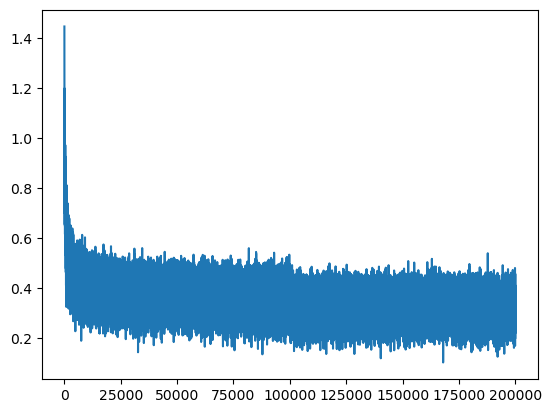

In [27]:
plt.plot(lossi)

In [29]:
@torch.no_grad() # this disables gradient computation, saves memory, and speeds up computation for the following function
def evaluate(split):
    x, y = {
        'train': (x_train, y_train),
        'val': (x_val, y_val),
        'test': (x_test, y_test)
    }[split]
    emb = C[x].view(-1, block_size*n_embed)
    a1 = torch.tanh((emb @ W1 + b1))
    z2 = a1 @ W2 + b2
    loss = F.cross_entropy(z2, y)
    print(split, 'loss:', loss.item())

evaluate('train')
evaluate('val')

train loss: 2.123866081237793
val loss: 2.1689343452453613


- what the decorator @torch.no_grad() does is that, whatever happens in the function, it will not be tracked by the autograd engine, so it will not be able to compute the gradients for it (it doesn't anticipate that there will do a backward pass on it) so `we basically tell PyTorch that we will not call .backward() on anything that happens in the function`
    - it is almost like that any tensor that is created in the function has requires_grad=False
    - so it is much more efficient when we are inferencing (it doesn't need to build the graph or store the intermediate activations for the backward pass)
- mine: another reason is that it behaves differently for things like BatchNorm, Dropout.
    - for the dropout it will not apply the dropout (it is not applied during test time or inferencing)
    - for the BatchNorm it will use the running statistics (the statistics that it has been computing during training) and it will not use the batch statistics

- we can also use `with torch.no_grad():` context manager


### Sampling from the model

In [39]:
for _ in range(20):
    out = []
    context = [0] * block_size # we start with the '.' index, block_size times
    while True:
        emb = C[torch.tensor(context)].view(1,-1) # 1Xblock_size -> 1Xblock_sizeXemb_dim
        a1 = torch.tanh((emb @ W1 + b1))
        z2 = a1 @ W2 + b2
        probs = F.softmax(z2, dim=1)
        next_char_idx = torch.multinomial(probs.view(-1), 1).item()
        context = context[1:] + [next_char_idx] # shift the context by one
        out.append(next_char_idx)
        if next_char_idx == 0:
            break

    # print the example now
    print(''.join([itos[i] for i in out]))

shalayna.
way.
hadia.
oakmeer.
kachter.
kori.
aylany.
lashikitrer.
atrie.
anovalenn.
brearmeel.
asomari.
sir.
freem.
via.
weef.
aylan.
cheis.
camri.
win.


- the names of the mlp are not fully name-like, but much better than the bi-gram model

## Initialization of the weights
- the first thing we will talk about is the initialization of the weights
- our network is very improperly initialized (there are multiple things wrong with it)
    - as we see the first loss is 27 (way too high), as it rapidly decreases to around 3
    - in training neural networks, it is almost always the case that we will have a rough idea of what loss to expect at initialization
        - it depends on the loss function and the problem setup
- for our example, we have 27 characters that could come next, and we have no reason to believe that any of them is more likely than the others
    - so the initial probability for them should be the same (1/27) 
    - so the initial loss should be -log(1/27) = 3.3
- so to achieve that we will need to make the logits initially comparable to each other

In [40]:
-torch.tensor(1/27.0).log()

tensor(3.2958)

- that is the initial loss we should expect (much lower than 27)

- what happened with our case above, is that our initial neural network (sampled from a normal distribution) created a probability distribution that is messed up
    - some characters are very confident (wrong characters) and some are very unconfident (right characters)
    - so the neural network is very confidently wrong 

- Examples

In [41]:
# 4D example of the issue
logits = torch.tensor([0.0,0.0,0.0,0.0])
probs = F.softmax(logits, dim=0)
loss = -probs[2].log()
probs, loss

(tensor([0.2500, 0.2500, 0.2500, 0.2500]), tensor(1.3863))

- in the above example, we assigned equal probabilities to them (1/4) as they have the same logits, and in this case no matter what is the label (it is 2 in this case, but change it if you like), the loss will be the same -log(1/4) = 1.39
    - so the loss should be around 1.39

In [42]:
# 4D example of the issue
logits = torch.tensor([20,30,0.0,15.5])
probs = F.softmax(logits, dim=0)
loss = -probs[2].log()
probs, loss

(tensor([4.5398e-05, 9.9995e-01, 9.3572e-14, 5.0432e-07]), tensor(30.0000))

- but when the neural network is confident about some characters more than others at the beginning -randomly-, we could get very high loss if the label corresponds to a low-probability character (like above) -which will happen most of the time-

In [43]:
# 4D example of the issue
logits = torch.tensor([20,30,0.0,15.5])
probs = F.softmax(logits, dim=0)
loss = -probs[1].log()
probs, loss

(tensor([4.5398e-05, 9.9995e-01, 9.3572e-14, 5.0432e-07]), tensor(4.5897e-05))

- or very low loss if the label corresponds to a high-probability character (like the above example) (but that is very rare compared to the above scenario)

In [52]:
steps = 200000
batch_size = 32
lossi = []

n_embed = 10 # dimension of the embedding vectors
n_hidden = 200 # number of hidden units
vocab_size = len(stoi)

g = torch.Generator().manual_seed(2147483647)
# parameters
C = torch.randn((vocab_size, n_embed)             , generator=g)
W1 = torch.randn((block_size * n_embed ,n_hidden) , generator=g)
b1 = torch.randn((n_hidden,)                      , generator=g)
W2 = torch.randn((n_hidden,vocab_size)            , generator=g)
b2 = torch.randn((vocab_size,)                    , generator=g)
parameters = [C, W1, b1, W2, b2] # all parameters
for p in parameters:
    p.requires_grad = True

for i in range(steps):
    # mini-batch
    idx = torch.randint(0, x_train.shape[0], (batch_size,), generator=g) # random indices of shape (batch_size,)

    # Forward pass
    emb = C[x_train[idx]].view(-1, block_size*n_embed) # mX(embed_size*block_size)
    a1 = torch.tanh((emb @ W1 + b1)) # mX(embed_size*blocksize) @ (embed_size*blocksize)Xn_hidden = mXn_hidden + 1Xn_hidden = mXn_hidden
    z2 = a1 @ W2 + b2 # mXn_hidden @ n_hiddenXvocab_size = mXvocab_size + 1Xvocab_size = mXvocab_size
    # Compute loss
    loss = F.cross_entropy(z2, y_train[idx]) # cross entropy loss with logits z2 (mXvocab_size) and labels of shape (m,)


    # Backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # learning rate decay
    lr = 0.1 if i < 100000 else 0.01
    # Update the parameters
    for p in parameters:
        p.data -= p.grad * lr
    

    # track stats
    if i % 10000 == 0:
        print(f"Step {i/steps*100:.2f}%", loss.item())

    lossi.append(loss.log10().item())
    break

z2[0]

Step 0.00% 27.881729125976562


tensor([ -2.3527,  36.4366, -10.7306,   5.7165,  18.6409, -11.6998,  -2.1991,
          1.8535,  10.9996,  10.6730,  12.3507, -10.3809,   4.7243, -24.4257,
         -8.5909,   1.9023, -12.2744, -12.4751, -23.2778,  -2.0163,  25.8767,
         14.2108,  17.7691, -10.9204, -20.7335,   6.4560,  11.1615],
       grad_fn=<SelectBackward0>)

- we see that because of the random initialization, the logits have extreme values (more confident about some characters than others randomly), that what makes the loss very high at the beginning

- instead, the logits should be equal to each other at the beginning , so that the probabilities are all the same (1/27), but we will make them comparable to each other -not exactly equal so that we can break the symmetry, otherwise all neurons will have the same weights and updates- 
    - `so, we want the logits -therefore the probabilities- to be comparable to each other at -preferably around 0- at the beginning`, this way the neural network is not confident about any character than the others at the beginning

- so, at the beginning $z2 = w2 @ a1 + b2$ 
    - we don't want to add a bias of random numbers to the logits (so we will initialize the biases to 0)
    - if we want logits to be small and compareable around 0, we will want $w2$ to be small (because we multiply it by a1), so we will multiply the random numbers generated in w2 with 0.01 

In [58]:
steps = 200000
batch_size = 32
lossi = []

n_embed = 10 # dimension of the embedding vectors
n_hidden = 200 # number of hidden units
vocab_size = len(stoi)

g = torch.Generator().manual_seed(2147483647)
# parameters
C = torch.randn((vocab_size, n_embed)             , generator=g)
W1 = torch.randn((block_size * n_embed ,n_hidden) , generator=g)
b1 = torch.randn((n_hidden,)                      , generator=g)
W2 = torch.randn((n_hidden,vocab_size)            , generator=g) * 0.01
b2 = torch.randn((vocab_size,)                    , generator=g) * 0
parameters = [C, W1, b1, W2, b2] # all parameters
for p in parameters:
    p.requires_grad = True

for i in range(steps):
    # mini-batch
    idx = torch.randint(0, x_train.shape[0], (batch_size,), generator=g) # random indices of shape (batch_size,)

    # Forward pass
    emb = C[x_train[idx]].view(-1, block_size*n_embed) # mX(embed_size*block_size)
    a1 = torch.tanh((emb @ W1 + b1)) # mX(embed_size*blocksize) @ (embed_size*blocksize)Xn_hidden = mXn_hidden + 1Xn_hidden = mXn_hidden
    z2 = a1 @ W2 + b2 # mXn_hidden @ n_hiddenXvocab_size = mXvocab_size + 1Xvocab_size = mXvocab_size
    # Compute loss
    loss = F.cross_entropy(z2, y_train[idx]) # cross entropy loss with logits z2 (mXvocab_size) and labels of shape (m,)


    # Backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # learning rate decay
    lr = 0.1 if i < 100000 else 0.01
    # Update the parameters
    for p in parameters:
        p.data -= p.grad * lr
    

    # track stats
    if i % 10000 == 0:
        print(f"Step {i/steps*100:.2f}%", loss.item())

    lossi.append(loss.log10().item())
    break

z2[0]

Step 0.00% 3.322058916091919


tensor([-0.0249,  0.3523, -0.1267,  0.0541,  0.1662, -0.1171, -0.0140,  0.0124,
         0.0921,  0.1135,  0.1362, -0.0925,  0.0444, -0.2459, -0.0971,  0.0125,
        -0.0957, -0.1376, -0.2329, -0.0137,  0.2452,  0.1616,  0.1665, -0.1094,
        -0.2154,  0.0725,  0.1141], grad_fn=<SelectBackward0>)

- notice that the logits are comparable therefore the probabilities are comparable, therefore the loss is around what we expect
- and at the same time they have some differences (entropy) so that the neural network breaks the symmetry

train with the new initialization

In [59]:
steps = 200000
batch_size = 32
lossi = []

n_embed = 10 # dimension of the embedding vectors
n_hidden = 200 # number of hidden units
vocab_size = len(stoi)

g = torch.Generator().manual_seed(2147483647)
# parameters
C = torch.randn((vocab_size, n_embed)             , generator=g)
W1 = torch.randn((block_size * n_embed ,n_hidden) , generator=g)
b1 = torch.randn((n_hidden,)                      , generator=g)
W2 = torch.randn((n_hidden,vocab_size)            , generator=g) * 0.01
b2 = torch.randn((vocab_size,)                    , generator=g) * 0
parameters = [C, W1, b1, W2, b2] # all parameters
for p in parameters:
    p.requires_grad = True

for i in range(steps):
    # mini-batch
    idx = torch.randint(0, x_train.shape[0], (batch_size,), generator=g) # random indices of shape (batch_size,)

    # Forward pass
    emb = C[x_train[idx]].view(-1, block_size*n_embed) # mX(embed_size*block_size)
    a1 = torch.tanh((emb @ W1 + b1)) # mX(embed_size*blocksize) @ (embed_size*blocksize)Xn_hidden = mXn_hidden + 1Xn_hidden = mXn_hidden
    z2 = a1 @ W2 + b2 # mXn_hidden @ n_hiddenXvocab_size = mXvocab_size + 1Xvocab_size = mXvocab_size
    # Compute loss
    loss = F.cross_entropy(z2, y_train[idx]) # cross entropy loss with logits z2 (mXvocab_size) and labels of shape (m,)


    # Backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # learning rate decay
    lr = 0.1 if i < 100000 else 0.01
    # Update the parameters
    for p in parameters:
        p.data -= p.grad * lr
    

    # track stats
    if i % 10000 == 0:
        print(f"Step {i/steps*100:.2f}%", loss.item())

    lossi.append(loss.log10().item())

Step 0.00% 3.322058916091919
Step 5.00% 2.1899678707122803
Step 10.00% 2.419572114944458
Step 15.00% 2.606708288192749
Step 20.00% 2.060103178024292
Step 25.00% 2.498807191848755
Step 30.00% 2.3902435302734375
Step 35.00% 2.1343865394592285
Step 40.00% 2.3368799686431885
Step 45.00% 2.129892587661743
Step 50.00% 1.832906723022461
Step 55.00% 2.205291748046875
Step 60.00% 1.8539849519729614
Step 65.00% 2.456580638885498
Step 70.00% 2.1878623962402344
Step 75.00% 2.111790418624878
Step 80.00% 1.8955597877502441
Step 85.00% 1.864450216293335
Step 90.00% 2.0325801372528076
Step 95.00% 1.841695785522461


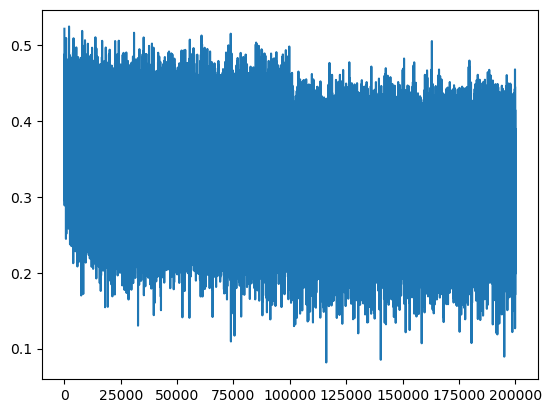

In [61]:
plt.plot(lossi)

- we no longer have that hockey stick shape
- remember that the hockey stick shape has a very high loss at the beginning, followed by a sudden and large drop in the beginning (because the optimization function squashes the large and different logits into comparable values first -easy gain-), then rearranges the logits to match the dataset -hard gain- which corresponds to the slow decrease in the loss afterwards as we train
- now we longer have that sudden drop because we already have comparable logits at the beginning, and all we see is a slow decrease from rearranging the logits to match the dataset

In [62]:
@torch.no_grad() # this disables gradient computation, saves memory, and speeds up computation for the following function
def evaluate(split):
    x, y = {
        'train': (x_train, y_train),
        'val': (x_val, y_val),
        'test': (x_test, y_test)
    }[split]
    emb = C[x].view(-1, block_size*n_embed)
    a1 = torch.tanh((emb @ W1 + b1))
    z2 = a1 @ W2 + b2
    loss = F.cross_entropy(z2, y)
    print(split, 'loss:', loss.item())

evaluate('train')
evaluate('val')

train loss: 2.0695888996124268
val loss: 2.131074905395508


- we even got a better loss eventually (because we spent more steps in re-arranging the logits to match the dataset), isntead of spending the first steps in squashing the logits to be comparable to each other

`Takeaway`: We want the logits before the softmax to be comparable to each other (so multiply the weights with a small number like 0.01 to make the final logits small and comparable to each other)

## Fixing the Saturated Tanh

In [7]:
steps = 200000
batch_size = 32
lossi = []

n_embed = 10 # dimension of the embedding vectors
n_hidden = 200 # number of hidden units
vocab_size = len(stoi)

g = torch.Generator().manual_seed(2147483647)
# parameters
C = torch.randn((vocab_size, n_embed)             , generator=g)
W1 = torch.randn((block_size * n_embed ,n_hidden) , generator=g)
b1 = torch.randn((n_hidden,)                      , generator=g)
W2 = torch.randn((n_hidden,vocab_size)            , generator=g) * 0.01
b2 = torch.randn((vocab_size,)                    , generator=g) * 0
parameters = [C, W1, b1, W2, b2] # all parameters
for p in parameters:
    p.requires_grad = True

for i in range(steps):
    # mini-batch
    idx = torch.randint(0, x_train.shape[0], (batch_size,), generator=g) # random indices of shape (batch_size,)

    # Forward pass
    emb = C[x_train[idx]].view(-1, block_size*n_embed) # mX(embed_size*block_size)
    z1 = emb @ W1 + b1
    a1 = torch.tanh(z1) # mX(embed_size*blocksize) @ (embed_size*blocksize)Xn_hidden = mXn_hidden + 1Xn_hidden = mXn_hidden
    z2 = a1 @ W2 + b2 # mXn_hidden @ n_hiddenXvocab_size = mXvocab_size + 1Xvocab_size = mXvocab_size
    # Compute loss
    loss = F.cross_entropy(z2, y_train[idx]) # cross entropy loss with logits z2 (mXvocab_size) and labels of shape (m,)


    # Backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # learning rate decay
    lr = 0.1 if i < 100000 else 0.01
    # Update the parameters
    for p in parameters:
        p.data -= p.grad * lr
    

    # track stats
    if i % 10000 == 0:
        print(f"Step {i/steps*100:.2f}%", loss.item())

    lossi.append(loss.log10().item())
    break

Step 0.00% 3.322058916091919


- even though the initial loss is good now, there is still a problem with the activation function of the hidden state

In [8]:
a1

tensor([[ 0.8100, -0.8997, -0.9993,  ..., -0.9097, -1.0000,  1.0000],
        [-1.0000, -0.9571, -0.7145,  ...,  0.4898,  0.9090,  0.9937],
        [ 0.9983, -0.3340,  1.0000,  ...,  0.9443,  0.9905,  1.0000],
        ...,
        [-1.0000,  0.9604, -0.1418,  ..., -0.1266,  1.0000,  1.0000],
        [-1.0000, -0.4385, -0.8882,  ..., -0.3316,  0.9995,  1.0000],
        [-1.0000,  0.9604, -0.1418,  ..., -0.1266,  1.0000,  1.0000]],
       grad_fn=<TanhBackward0>)

![image.png](assets/tanh.jfif)

- notice how many elements are 1 or -1 (saturated) 
    - that is because of the tanh, it squashes the logits to be between 1 and -1
    - with all logits above 3 to be around 1 and all logits below -3 to be -1
    - that is again because of the large logits (which is because of the large random weights)

In [17]:
F.tanh(torch.tensor(-3)), F.tanh(torch.tensor(3))

(tensor(-0.9951), tensor(0.9951))

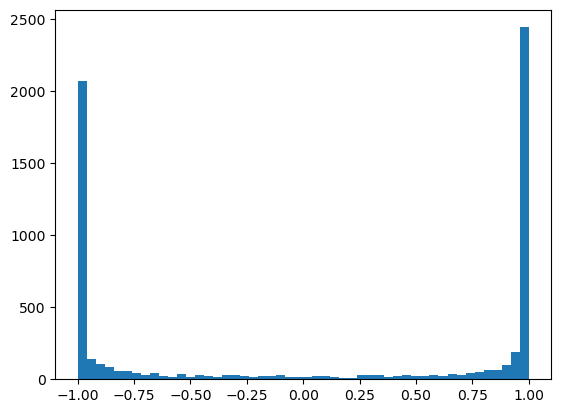

In [18]:
plt.hist(a1.reshape(-1).tolist(),50);

- notice that most the values by far take on -1 and 1, that means z1 has most of the values taking ranges outer than -3 to 3

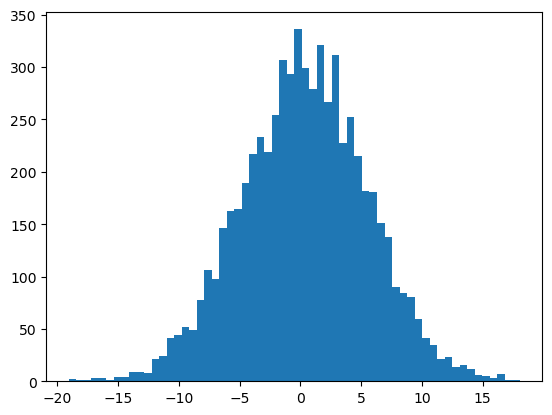

In [9]:
plt.hist(z1.reshape(-1).tolist(),60);

- we see that we have a broad range between -15 and 15, that is why the tanh squashes most of them to 1 and -1
- so what happens to that in the backward pass? all the 1s and -1s will have a gradient of 0
    - the derivative of the tanh, is 1 - tanh(x)^2, so for the values 1 and -1
        - $1 - 1^2 = 0$
        - $1 - (-1)^2 = 0$
    ```python
    # from notebook1: auto grad
    def tanh(self):
        x = self.data
        tanhx = (np.exp(x) - np.exp(-x)) / (np.exp(x) + np.exp(-x))
        out = Value(tanhx, (self, ), "tanh")
        def _backward():
            self.grad += out.grad * (1 - tanhx**2)
        out._backward = _backward
        return out
    ```
    - so, no matter that the upstream gradient is, the local gradient (derivative of the tanh) will be 0 for the values 1 and -1


- which makes sense, because if we look at the tanh function, 1 and -1 have slopes of 0, so the gradient will be 0
    - so changing the input around that saturated region doesn't affect the output, so there is no impact on the loss, so the gradient will be 0

- so, if most of the neurons are in the flat region, then the gradients that are flowing throw the network will get destroyed (multiplied by 0) at this layer
- so, for the tanh, we want the values to be around 0, so that the local gradient is $1 - (0)^2 = 1$ (and the upstream gradient will be multiplied by 1,basically pass as it is)

In [18]:
local_gradient = 1 - (F.tanh(torch.tensor(0.0)))**2
local_gradient

tensor(1.)

- the upstream gradient will pass as it is as we see above, if the output is exactly 0

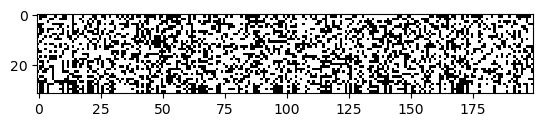

In [25]:
plt.imshow(a1.abs() > 0.99, cmap='gray',interpolation='nearest')

- another way to see how many neurons are at 1 and -1 for the 32 examples -rows- and for all the 200 neurons -columns- a white means an activation of 1 or -1, all of these neurons will have a gradient of 0
- we would be in a lot of trouble if we have a white column (that means the corresponding neuron will not be updated at all from any of the 32 examples, a dead neuron)
    - but luckily, all neurons receive some gradient from some of the examples (not all of them are white), that what makes it learn eventually , but still they receive gradients from very few examples 
- in other words, if all examples land at the tail in the beginning, then this neuron will never learn

- that is true for other activation functions
    - like `sigmoid` (for values of z that are larger than 3 or smaller than -3) will output 0 and 1
        - since the derivative of the sigmoid is $\sigma(x)(1-\sigma(x))$, then $0(1-0) = 0$ and $1(1-1) = 0$
    - like `relu` (for -ve values of z) will output 0
        - and the derivative of the relu is 0 for -ve values of z
        - sometimes that can happen during initialization (the weights and biases make it such taht the z is -ve), but also  during optimization (if we have like too large learning rate, the weights and biases can be be updated to push the z to be -ve for all examples) like a permenant brain damage in the mind of the neural network

- mine: in order for a relu to be dead it must output 0 for all examples, that can happen because of a bad initialization (which will lead to all z to be -ve), or because of a bad optimization like a large learning rate that will push the z to be -ve for all examples
    - but notice that if a certain example i has a -ve z, then the gradient will be 0 for that example, but it will be non-zero for the other examples, and the other examples might update the weights and biases in a way that will make the z of the example i to be +ve again (so it will not be dead anymore), but for it to be permanently dead, all examples must have -ve z

- other activation functions like `leaky relu` will not suffer from this problem, as they don't have flat tails

- so `how to solve this`? 
    - as we said, we need the z to be small and around 0, so we will multiply the weights with a small number (like 0.1), and also the biases to be 0 or random then multiplied by a small number as well
    - the Z before the tanh activation is some $w @ a + b$
        - we will make the weights $w$ smaller (so that the z is smaller), so that the tanh doesn't squash them to 1 and -1
        - we will make the biases $b$ to be 0 (so that the z is smaller), or just make them smaller and random to add a little bit of entropy to the z

In [38]:
steps = 200000
batch_size = 32
lossi = []

n_embed = 10 # dimension of the embedding vectors
n_hidden = 200 # number of hidden units
vocab_size = len(stoi)

g = torch.Generator().manual_seed(2147483647)
# parameters
C = torch.randn((vocab_size, n_embed)             , generator=g)
W1 = torch.randn((block_size * n_embed ,n_hidden) , generator=g) * 0.1
b1 = torch.randn((n_hidden,)                      , generator=g) * 0.01
W2 = torch.randn((n_hidden,vocab_size)            , generator=g) * 0.01
b2 = torch.randn((vocab_size,)                    , generator=g) * 0
parameters = [C, W1, b1, W2, b2] # all parameters
for p in parameters:
    p.requires_grad = True

for i in range(steps):
    # mini-batch
    idx = torch.randint(0, x_train.shape[0], (batch_size,), generator=g) # random indices of shape (batch_size,)

    # Forward pass
    emb = C[x_train[idx]].view(-1, block_size*n_embed) # mX(embed_size*block_size)
    z1 = emb @ W1 + b1
    a1 = torch.tanh(z1) # mX(embed_size*blocksize) @ (embed_size*blocksize)Xn_hidden = mXn_hidden + 1Xn_hidden = mXn_hidden
    z2 = a1 @ W2 + b2 # mXn_hidden @ n_hiddenXvocab_size = mXvocab_size + 1Xvocab_size = mXvocab_size
    # Compute loss
    loss = F.cross_entropy(z2, y_train[idx]) # cross entropy loss with logits z2 (mXvocab_size) and labels of shape (m,)


    # Backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # learning rate decay
    lr = 0.1 if i < 100000 else 0.01
    # Update the parameters
    for p in parameters:
        p.data -= p.grad * lr
    

    # track stats
    if i % 10000 == 0:
        print(f"Step {i/steps*100:.2f}%", loss.item())

    lossi.append(loss.log10().item())
    break

Step 0.00% 3.3068957328796387


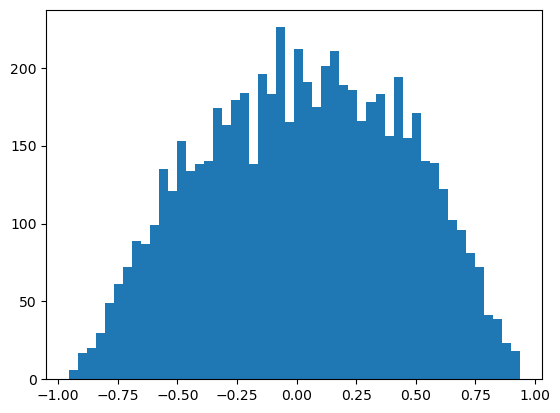

In [39]:
plt.hist(a1.reshape(-1).tolist(),50);

- see how since we have smaller z (by making the Ws and bs smaller), the tanh doesn't squash them to 1 and -1, in fact for the above example we don't have a single 1 or -1

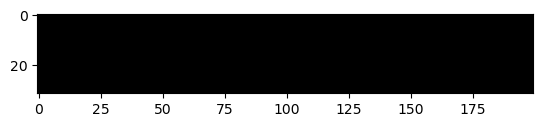

In [40]:
plt.imshow(a1.abs() > 0.99, cmap='gray',interpolation='nearest')

- there is no white at all :D, all neurons receive some gradient from all examples
- let's try to make Zs little larger by making the weights little larger (multiply them by 0.2 instead of 0.1)

In [41]:
steps = 200000
batch_size = 32
lossi = []

n_embed = 10 # dimension of the embedding vectors
n_hidden = 200 # number of hidden units
vocab_size = len(stoi)

g = torch.Generator().manual_seed(2147483647)
# parameters
C = torch.randn((vocab_size, n_embed)             , generator=g)
W1 = torch.randn((block_size * n_embed ,n_hidden) , generator=g) * 0.2
b1 = torch.randn((n_hidden,)                      , generator=g) * 0.01
W2 = torch.randn((n_hidden,vocab_size)            , generator=g) * 0.01
b2 = torch.randn((vocab_size,)                    , generator=g) * 0
parameters = [C, W1, b1, W2, b2] # all parameters
for p in parameters:
    p.requires_grad = True

for i in range(steps):
    # mini-batch
    idx = torch.randint(0, x_train.shape[0], (batch_size,), generator=g) # random indices of shape (batch_size,)

    # Forward pass
    emb = C[x_train[idx]].view(-1, block_size*n_embed) # mX(embed_size*block_size)
    z1 = emb @ W1 + b1
    a1 = torch.tanh(z1) # mX(embed_size*blocksize) @ (embed_size*blocksize)Xn_hidden = mXn_hidden + 1Xn_hidden = mXn_hidden
    z2 = a1 @ W2 + b2 # mXn_hidden @ n_hiddenXvocab_size = mXvocab_size + 1Xvocab_size = mXvocab_size
    # Compute loss
    loss = F.cross_entropy(z2, y_train[idx]) # cross entropy loss with logits z2 (mXvocab_size) and labels of shape (m,)


    # Backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # learning rate decay
    lr = 0.1 if i < 100000 else 0.01
    # Update the parameters
    for p in parameters:
        p.data -= p.grad * lr
    

    # track stats
    if i % 10000 == 0:
        print(f"Step {i/steps*100:.2f}%", loss.item())

    lossi.append(loss.log10().item())
    break

Step 0.00% 3.3134593963623047


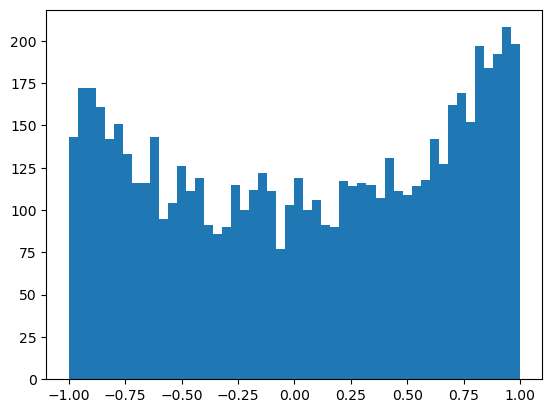

In [42]:
plt.hist(a1.reshape(-1).tolist(),50);

- we have some 1s and -1s, but they are not that many, so the neurons will learn from most of the examples

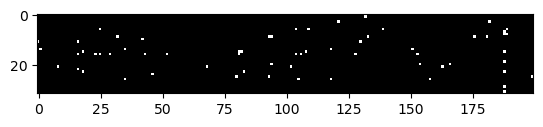

In [43]:
plt.imshow(a1.abs() > 0.99, cmap='gray',interpolation='nearest')

- that should be good to go, let's train

In [45]:
steps = 200000
batch_size = 32
lossi = []

n_embed = 10 # dimension of the embedding vectors
n_hidden = 200 # number of hidden units
vocab_size = len(stoi)

g = torch.Generator().manual_seed(2147483647)
# parameters
C = torch.randn((vocab_size, n_embed)             , generator=g)
W1 = torch.randn((block_size * n_embed ,n_hidden) , generator=g) * 0.2
b1 = torch.randn((n_hidden,)                      , generator=g) * 0.01
W2 = torch.randn((n_hidden,vocab_size)            , generator=g) * 0.01
b2 = torch.randn((vocab_size,)                    , generator=g) * 0
parameters = [C, W1, b1, W2, b2] # all parameters
for p in parameters:
    p.requires_grad = True

for i in range(steps):
    # mini-batch
    idx = torch.randint(0, x_train.shape[0], (batch_size,), generator=g) # random indices of shape (batch_size,)

    # Forward pass
    emb = C[x_train[idx]].view(-1, block_size*n_embed) # mX(embed_size*block_size)
    z1 = emb @ W1 + b1
    a1 = torch.tanh(z1) # mX(embed_size*blocksize) @ (embed_size*blocksize)Xn_hidden = mXn_hidden + 1Xn_hidden = mXn_hidden
    z2 = a1 @ W2 + b2 # mXn_hidden @ n_hiddenXvocab_size = mXvocab_size + 1Xvocab_size = mXvocab_size
    # Compute loss
    loss = F.cross_entropy(z2, y_train[idx]) # cross entropy loss with logits z2 (mXvocab_size) and labels of shape (m,)


    # Backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # learning rate decay
    lr = 0.1 if i < 100000 else 0.01
    # Update the parameters
    for p in parameters:
        p.data -= p.grad * lr
    

    # track stats
    if i % 10000 == 0:
        print(f"Step {i/steps*100:.2f}%", loss.item())

    lossi.append(loss.log10().item())

Step 0.00% 3.3134593963623047
Step 5.00% 2.1648271083831787
Step 10.00% 2.3060882091522217
Step 15.00% 2.4541397094726562
Step 20.00% 1.9786760807037354
Step 25.00% 2.2929723262786865
Step 30.00% 2.4232337474823
Step 35.00% 2.067997694015503
Step 40.00% 2.30954647064209
Step 45.00% 2.1207098960876465
Step 50.00% 1.8268617391586304
Step 55.00% 2.20448637008667
Step 60.00% 1.979655146598816
Step 65.00% 2.3945682048797607
Step 70.00% 2.100045919418335
Step 75.00% 2.1947994232177734
Step 80.00% 1.8619441986083984
Step 85.00% 1.7809184789657593
Step 90.00% 1.9672857522964478
Step 95.00% 1.8294628858566284


In [46]:
@torch.no_grad() # this disables gradient computation, saves memory, and speeds up computation for the following function
def evaluate(split):
    x, y = {
        'train': (x_train, y_train),
        'val': (x_val, y_val),
        'test': (x_test, y_test)
    }[split]
    emb = C[x].view(-1, block_size*n_embed)
    a1 = torch.tanh((emb @ W1 + b1))
    z2 = a1 @ W2 + b2
    loss = F.cross_entropy(z2, y)
    print(split, 'loss:', loss.item())

evaluate('train')
evaluate('val')

train loss: 2.0355966091156006
val loss: 2.1026785373687744


- we got a better loss, because less examples are saturated, and we have more gradients flowing through the network

- so originally
    - train loss is 2.12
    - valid loss is 2.16

- fix softmax confidently wrong (by making the Zs comparable to each other, by making the weights smaller)
    - train loss is 2.06
    - valid loss is 2.13

- fix tanh saturation (by making the Zs smaller, by making the weights smaller)
    - train loss is 2.03
    - valid loss is 2.10

- because the network is shallow, the optimization is easy and very forgiving, so we don't see a huge difference in the loss, but in deeper networks, the difference will be huge

## Initialization in the real world

- we made Ws smaller by hand, and chose the values to multiple the Ws with to make it smaller
- but we don't do that in the real world, obviously no one does this by hand for large networks with many layers and neurons

- there are relatively principled ways of setting these scales (that take into account these activation functions' properties like the flat regions and also the number of features coming as an input  -as the larger neurons the more W terms so the value we scale W by will be different) 
    - they do that with the aim to preserve the distribution of the activations and gradients as they flow through the network
        - like `Kaiming initialization` 

tensor(-0.0047) tensor(1.0191)
tensor(0.0369) tensor(0.9812)
tensor(0.0114) tensor(3.1662)


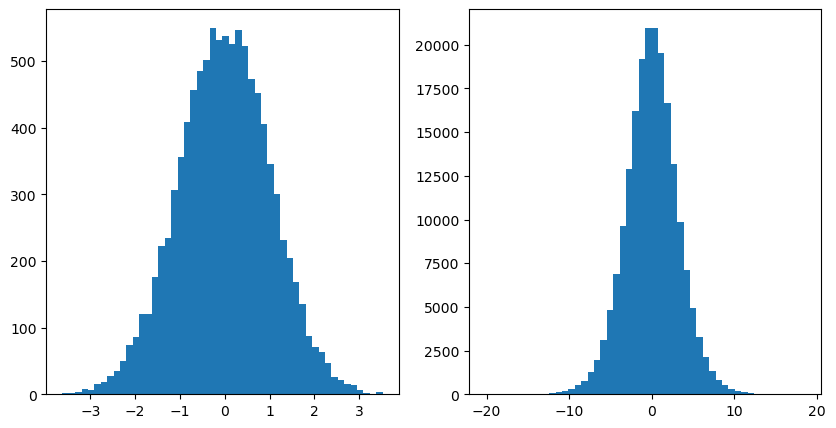

In [50]:
x = torch.randn(1000,10)
w = torch.randn(10,200)
z = x @ w
print(x.mean(), x.std())
print(w.mean(), w.std())
print(z.mean(), z.std())
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.hist(x.reshape(-1).tolist(),50);
plt.subplot(1,2,2)
plt.hist(z.reshape(-1).tolist(),50);

- in the above cell, we have some random input x (10 dimensional) with mean 0 and std 1 
- we also have Ws that with mean 0 and std 1
    - these each neuron multiplies the 10 dimensional input by 10 weights

- if we do X @ W, ignore the bias or assume it is 0, we notice that the mean of the output is 0 (same as the input), but the std was expanded to 3

- and we don't want that, we want most of the neural net to have relatively similar activations (so if the input is a gaussian, we want the output to be a gaussian as well, or whatever the input distribution is, we want the output to be the same distribution)
    - and the solution is to scale the Ws to preserve the distribution 
    - it turns out that the answer mathematically is to divide the Ws by the square root of the number of inputs to the neuron (10 in this case) $W = W  * \frac{1}{\sqrt{n_{inputs}}}$
    

tensor(-0.0088) tensor(0.9953)
tensor(0.0165) tensor(0.3110)
tensor(-0.0027) tensor(0.9817)


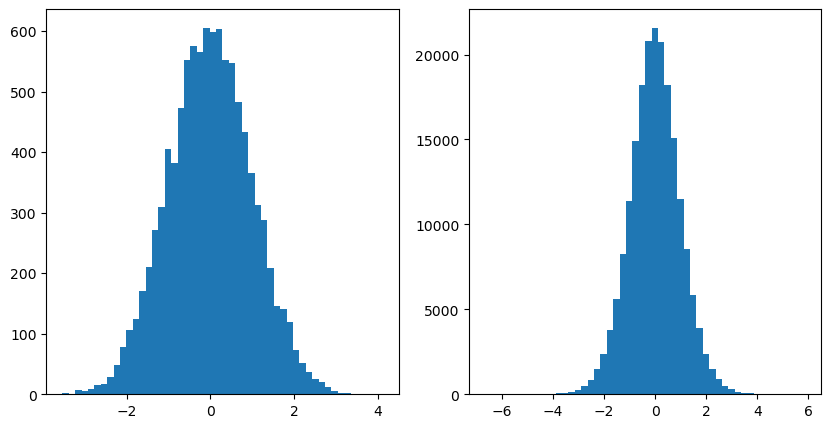

In [52]:
x = torch.randn(1000,10)
w = torch.randn(10,200) / 10**0.5
z = x @ w
print(x.mean(), x.std())
print(w.mean(), w.std())
print(z.mean(), z.std())
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.hist(x.reshape(-1).tolist(),50);
plt.subplot(1,2,2)
plt.hist(z.reshape(-1).tolist(),50);

- some papers have looked at how to initialize the weights in a way that make the activations well-behaved (don't expand to infinity or shrink to 0)
    - like `Xavier initialization` (for tanh and sigmoid) and `Kaiming initialization` (for relu and leaky relu)

- `Kaiming initialization` studied CNNs and especially the `Relu` activation function
    - the relu squashes the negative values to 0, and the positive values pass as they are
    - so, we are basically throwing away half of the distribution (the negative half)
    - so, they found in the analysis that we have to compensate for that by multiplying the weights by 2 divided by square root of number of inputs to the neuron $W = W  * \frac{2}{\sqrt{n_{inputs}}}$
        - mine: it is the same as the example above, we multiply the weights by $\frac{1}{\sqrt{n_{inputs}}}$, to compensate for the $W @ X$ and we multiply by 2 (which is called the gain) to compensate for the relu squashing the negative values after it
    - they also studied the backpropagation and make sure that the gradients are well-behaved as well, and they found that if the forward pass is well-initialized, the backward pass will be well-initialized up to a constant factor (the ratio of the number of neurons outputted by the layer and the number of neurons inputted to the layer), but imperically this doesn't matter that much

- similarly for the tanh, it squashes the values to -1 and 1, so in order to preserve the distribution, we have to compensate that squashing and the gain for the tanh is 5/3 (so we eventually multiply the weights by $W = W  * \frac{5/3}{\sqrt{n_{inputs}}}$), mine: where the $\frac{1}{\sqrt{n_{inputs}}}$ is to compensate for the $W @ X$ and the 5/3 is to compensate for the tanh squashing the values to -1 and 1

- `kaiming_normal_` is the function that does the kaiming initialization for us in PyTorch
    - this is probably the most common way of initializing neural networks now
    - it takes the `tensor` and the `mode` (fan_in or fan_out, which decides whether to preserve the activations or the gradients, but we said it doesn't matter that much imperically), and it takes the `nonlinearity` (because we multiply by different gains as we said depending on the nonlinearity, just like 1 sigmoid, and 2 for relu and leaky relu, and 5/3 for tanh)



- This was extrmely important in the past (we had to be careful with the activations and gradients and their ranges or histograms), and we had to be careful with the sclaing and so on,
    - but there are modern innovations that made everyhting much more stable and well-behaved (so it became less important to initialize these networks exactly right)

    - some of these modren innovations are 
        - `residual connections` (skip connections) that make the gradients flow much better (so we don't have to worry about the gradients vanishing or exploding that much)
        - the use of several layers of normalization
            - `batch normalization` (which normalizes the activations to have mean 0 and std 1, so that the activations are well-behaved and the gradients are well-behaved)
            - `layer normalization` and `group normalization` 
        - much better optimizers, unlike the SGD we use here, these optimizers are much more stable and robust to the learning rate and the initialization

- `in practice, what should we do`?
    - Andrej Karpathy initializes the neural networks by normalizing the weights by the square root of fan_in (number of inputs to the layer)

In [53]:
(5/3)/((block_size * n_embed)**0.5)

0.3042903097250923

- so we will multiply W1 with 0.3 instead of 0.2 previously

In [55]:
steps = 200000
batch_size = 32
lossi = []

n_embed = 10 # dimension of the embedding vectors
n_hidden = 200 # number of hidden units
vocab_size = len(stoi)

g = torch.Generator().manual_seed(2147483647)
# parameters
C = torch.randn((vocab_size, n_embed)             , generator=g)
W1 = torch.randn((block_size * n_embed ,n_hidden) , generator=g) * (5/3)/((block_size * n_embed)**0.5) # nin = block_size * n_embed, and gain = 5/3 because we will use tanh after it
b1 = torch.randn((n_hidden,)                      , generator=g) * 0.01
W2 = torch.randn((n_hidden,vocab_size)            , generator=g) * 1/(n_hidden**0.5) # nin = n_hidden
b2 = torch.randn((vocab_size,)                    , generator=g) * 0
parameters = [C, W1, b1, W2, b2] # all parameters
for p in parameters:
    p.requires_grad = True

for i in range(steps):
    # mini-batch
    idx = torch.randint(0, x_train.shape[0], (batch_size,), generator=g) # random indices of shape (batch_size,)

    # Forward pass
    emb = C[x_train[idx]].view(-1, block_size*n_embed) # mX(embed_size*block_size)
    z1 = emb @ W1 + b1
    a1 = torch.tanh(z1) # mX(embed_size*blocksize) @ (embed_size*blocksize)Xn_hidden = mXn_hidden + 1Xn_hidden = mXn_hidden
    z2 = a1 @ W2 + b2 # mXn_hidden @ n_hiddenXvocab_size = mXvocab_size + 1Xvocab_size = mXvocab_size
    # Compute loss
    loss = F.cross_entropy(z2, y_train[idx]) # cross entropy loss with logits z2 (mXvocab_size) and labels of shape (m,)


    # Backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # learning rate decay
    lr = 0.1 if i < 100000 else 0.01
    # Update the parameters
    for p in parameters:
        p.data -= p.grad * lr
    

    # track stats
    if i % 10000 == 0:
        print(f"Step {i/steps*100:.2f}%", loss.item())

    lossi.append(loss.log10().item())

Step 0.00% 3.662520408630371
Step 5.00% 2.2123239040374756
Step 10.00% 2.378249406814575
Step 15.00% 2.511378288269043
Step 20.00% 1.9936505556106567
Step 25.00% 2.3216731548309326
Step 30.00% 2.4264659881591797
Step 35.00% 2.144197702407837
Step 40.00% 2.2339749336242676
Step 45.00% 2.1546711921691895
Step 50.00% 1.871434211730957
Step 55.00% 2.0707054138183594
Step 60.00% 1.9714800119400024
Step 65.00% 2.338045120239258
Step 70.00% 2.148895025253296
Step 75.00% 2.164431571960449
Step 80.00% 1.79453706741333
Step 85.00% 1.7688430547714233
Step 90.00% 1.905971884727478
Step 95.00% 1.8047813177108765


In [56]:
@torch.no_grad() # this disables gradient computation, saves memory, and speeds up computation for the following function
def evaluate(split):
    x, y = {
        'train': (x_train, y_train),
        'val': (x_val, y_val),
        'test': (x_test, y_test)
    }[split]
    emb = C[x].view(-1, block_size*n_embed)
    a1 = torch.tanh((emb @ W1 + b1))
    z2 = a1 @ W2 + b2
    loss = F.cross_entropy(z2, y)
    print(split, 'loss:', loss.item())

evaluate('train')
evaluate('val')

train loss: 2.038471221923828
val loss: 2.103687286376953


- we got to the same spot, but now we have a systematic way of scaling the Ws instead of just plotting the histograms of the activations and gradients and trying to guess what to multiply them with to make them well-behaved

## Batch Normalization

- it is time to introduce one of the modern innovations that made the exact initialization of the neural networks less important
- it came out in 2015, by a team at Google, and it made an impact on the field as we became able to train much deeper networks

- we talked about how we want to logits not to be way too small (then the tanh will not do anything, as if are not having any nonlinearity), and we don't want them to be way too large (then the tanh will squash them to 1 and -1, and the gradients will be 0)
    - so we want them to be around 0 (roughly gaussian, with 0 mean and 1 std, at least at the beginning)

- the idea of batch normalization is, if we would like the hidden states to be roughly gaussian, so why don't we just normalize them to be gaussian :D 
    - we can just do that beause standardizing is a perfectly differentiable operation (we can backpropagate through it, and that means we can learn the parameters of the standardization)
    - mine: so we start with gaussian standardization, and then we let the neural network learn the parameters of the standardization (the mean and std) it likes

In [57]:
steps = 200000
batch_size = 32
lossi = []

n_embed = 10 # dimension of the embedding vectors
n_hidden = 200 # number of hidden units
vocab_size = len(stoi)

g = torch.Generator().manual_seed(2147483647)
# parameters
C = torch.randn((vocab_size, n_embed)             , generator=g)
W1 = torch.randn((block_size * n_embed ,n_hidden) , generator=g) * (5/3)/((block_size * n_embed)**0.5) # nin = block_size * n_embed, and gain = 5/3 because we will use tanh after it
b1 = torch.randn((n_hidden,)                      , generator=g) * 0.01
W2 = torch.randn((n_hidden,vocab_size)            , generator=g) * 1/(n_hidden**0.5) # nin = n_hidden
b2 = torch.randn((vocab_size,)                    , generator=g) * 0
parameters = [C, W1, b1, W2, b2] # all parameters
for p in parameters:
    p.requires_grad = True

for i in range(steps):
    # mini-batch
    idx = torch.randint(0, x_train.shape[0], (batch_size,), generator=g) # random indices of shape (batch_size,)

    # Forward pass
    emb = C[x_train[idx]].view(-1, block_size*n_embed) # mX(embed_size*block_size)
    z1 = emb @ W1 + b1
    a1 = torch.tanh(z1) # mX(embed_size*blocksize) @ (embed_size*blocksize)Xn_hidden = mXn_hidden + 1Xn_hidden = mXn_hidden
    z2 = a1 @ W2 + b2 # mXn_hidden @ n_hiddenXvocab_size = mXvocab_size + 1Xvocab_size = mXvocab_size
    # Compute loss
    loss = F.cross_entropy(z2, y_train[idx]) # cross entropy loss with logits z2 (mXvocab_size) and labels of shape (m,)


    # Backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # learning rate decay
    lr = 0.1 if i < 100000 else 0.01
    # Update the parameters
    for p in parameters:
        p.data -= p.grad * lr
    

    # track stats
    if i % 10000 == 0:
        print(f"Step {i/steps*100:.2f}%", loss.item())

    lossi.append(loss.log10().item())
    break

Step 0.00% 3.662520408630371


In [61]:
z1.mean(dim=0, keepdim=True).shape # that is the mean of each logit over the batch

torch.Size([1, 200])

In [62]:
z1.std(dim=0, keepdim=True).shape # that is the mean of each logit over the batch

torch.Size([1, 200])

then we subtract the mean and divide by the std (so that each neuron has a mean of 0 and std of 1)

In [64]:
z1_standardized = (z1 - z1.mean(dim=0, keepdim=True)) / z1.std(dim=0, keepdim=True)

In [65]:
z1_standardized.mean(dim=0, keepdim=True), z1_standardized.std(dim=0, keepdim=True)

(tensor([[-2.6077e-08,  7.4506e-09, -7.4506e-09, -4.8429e-08,  9.3132e-09,
          -2.2352e-08,  7.4506e-09,  3.7253e-09,  3.7253e-09,  1.1176e-08,
          -1.8626e-08,  2.6077e-08,  1.4901e-08,  1.8626e-08, -7.4506e-09,
           1.9092e-08, -1.8626e-08,  0.0000e+00,  0.0000e+00, -5.9605e-08,
           1.3039e-08,  2.9802e-08,  0.0000e+00, -1.4901e-08,  7.4506e-09,
           2.2352e-08,  2.4214e-08, -2.9802e-08,  9.3132e-09,  4.4703e-08,
          -2.9802e-08, -1.1176e-08, -1.4901e-08, -1.4901e-08,  1.4901e-08,
           4.8429e-08,  0.0000e+00, -1.4901e-08,  7.4506e-09,  3.7253e-09,
          -1.1176e-08,  1.4901e-08, -1.9558e-08,  0.0000e+00, -1.8626e-08,
           3.7253e-09,  2.2352e-08,  2.2352e-08, -5.2154e-08, -5.9605e-08,
          -7.4506e-09, -9.3132e-09,  1.1176e-08,  4.4703e-08,  2.2352e-08,
           1.4901e-08,  1.4901e-08,  7.4506e-09, -7.4506e-09,  3.7253e-08,
           4.4703e-08, -7.4506e-08,  7.4506e-09,  7.4506e-09, -1.8626e-08,
          -5.2154e-08,  2

- now the logits have a mean of 0 and std of 1 (every single neuron now and its firing rate will be exactly unit gaussian for the batch -that is why it is called batch normalization-)
- but we said we want them to be gaussian only at the beginning, we don't always want them to be gaussian, so we let the neural network learn the mean and std suitable for the optimization whatever it is
    - and the way to do that is to multiply by a learnable parameter gamma -learnable standard deviation- and add a learnable parameter beta -learnable mean- (so that the neural network moves this gaussian around to a different mean or scale it up or down to a different std)

In [66]:
# if we want to change the mean to 5 and std to 2
z1_rescaled = z1_standardized * 2 + 5
z1_rescaled.mean(dim=0, keepdim=True), z1_rescaled.std(dim=0, keepdim=True)

(tensor([[5.0000, 5.0000, 5.0000, 5.0000, 5.0000, 5.0000, 5.0000, 5.0000, 5.0000,
          5.0000, 5.0000, 5.0000, 5.0000, 5.0000, 5.0000, 5.0000, 5.0000, 5.0000,
          5.0000, 5.0000, 5.0000, 5.0000, 5.0000, 5.0000, 5.0000, 5.0000, 5.0000,
          5.0000, 5.0000, 5.0000, 5.0000, 5.0000, 5.0000, 5.0000, 5.0000, 5.0000,
          5.0000, 5.0000, 5.0000, 5.0000, 5.0000, 5.0000, 5.0000, 5.0000, 5.0000,
          5.0000, 5.0000, 5.0000, 5.0000, 5.0000, 5.0000, 5.0000, 5.0000, 5.0000,
          5.0000, 5.0000, 5.0000, 5.0000, 5.0000, 5.0000, 5.0000, 5.0000, 5.0000,
          5.0000, 5.0000, 5.0000, 5.0000, 5.0000, 5.0000, 5.0000, 5.0000, 5.0000,
          5.0000, 5.0000, 5.0000, 5.0000, 5.0000, 5.0000, 5.0000, 5.0000, 5.0000,
          5.0000, 5.0000, 5.0000, 5.0000, 5.0000, 5.0000, 5.0000, 5.0000, 5.0000,
          5.0000, 5.0000, 5.0000, 5.0000, 5.0000, 5.0000, 5.0000, 5.0000, 5.0000,
          5.0000, 5.0000, 5.0000, 5.0000, 5.0000, 5.0000, 5.0000, 5.0000, 5.0000,
          5.0000

- see how easy it is to adjust the distribution of the logits now that it has been standardized 
    - so $z_rescaled = \gamma * z_{standardized} + \beta$, where $\gamma$ is the learnable std and $\beta$ is the learnable mean

In [67]:
steps = 200000
batch_size = 32
lossi = []

n_embed = 10 # dimension of the embedding vectors
n_hidden = 200 # number of hidden units
vocab_size = len(stoi)

g = torch.Generator().manual_seed(2147483647)
# parameters
C = torch.randn((vocab_size, n_embed)             , generator=g)
W1 = torch.randn((block_size * n_embed ,n_hidden) , generator=g) * (5/3)/((block_size * n_embed)**0.5) # nin = block_size * n_embed, and gain = 5/3 because we will use tanh after it
b1 = torch.randn((n_hidden,)                      , generator=g) * 0.01
W2 = torch.randn((n_hidden,vocab_size)            , generator=g) * 1/(n_hidden**0.5) # nin = n_hidden
b2 = torch.randn((vocab_size,)                    , generator=g) * 0
gamma1 = torch.ones(1,n_hidden) # will be ones at the beginning (no change to the mean)
beta1 = torch.zeros(1,n_hidden) # will be zeros at the beginning (no change to the std)
parameters = [C, W1, b1, W2, b2, gamma1, beta1] # all parameters

for p in parameters:
    p.requires_grad = True

for i in range(steps):
    # mini-batch
    idx = torch.randint(0, x_train.shape[0], (batch_size,), generator=g) # random indices of shape (batch_size,)

    # Forward pass
    emb = C[x_train[idx]].view(-1, block_size*n_embed) # mX(embed_size*block_size)
    z1 = emb @ W1 + b1
    z1_standardized = (z1 - z1.mean(dim=0, keepdim=True)) / z1.std(dim=0, keepdim=True)
    z1_rescaled = z1_standardized * gamma1 + beta1
    a1 = torch.tanh(z1_rescaled) # mX(embed_size*blocksize) @ (embed_size*blocksize)Xn_hidden = mXn_hidden + 1Xn_hidden = mXn_hidden
    z2 = a1 @ W2 + b2 # mXn_hidden @ n_hiddenXvocab_size = mXvocab_size + 1Xvocab_size = mXvocab_size
    # Compute loss
    loss = F.cross_entropy(z2, y_train[idx]) # cross entropy loss with logits z2 (mXvocab_size) and labels of shape (m,)


    # Backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # learning rate decay
    lr = 0.1 if i < 100000 else 0.01
    # Update the parameters
    for p in parameters:
        p.data -= p.grad * lr
    

    # track stats
    if i % 10000 == 0:
        print(f"Step {i/steps*100:.2f}%", loss.item())

    lossi.append(loss.log10().item())

Step 0.00% 3.5771939754486084
Step 5.00% 2.1652073860168457
Step 10.00% 2.4166934490203857
Step 15.00% 2.443561553955078
Step 20.00% 2.011080741882324
Step 25.00% 2.3681178092956543
Step 30.00% 2.4293510913848877
Step 35.00% 2.1056463718414307
Step 40.00% 2.3539512157440186
Step 45.00% 2.138922691345215
Step 50.00% 1.9416979551315308
Step 55.00% 2.3648266792297363
Step 60.00% 1.9323335886001587
Step 65.00% 2.482499837875366
Step 70.00% 2.3173859119415283
Step 75.00% 2.1054091453552246
Step 80.00% 1.9775984287261963
Step 85.00% 1.8040004968643188
Step 90.00% 1.9797155857086182
Step 95.00% 1.8384023904800415


In [68]:
@torch.no_grad() # this disables gradient computation, saves memory, and speeds up computation for the following function
def evaluate(split):
    x, y = {
        'train': (x_train, y_train),
        'val': (x_val, y_val),
        'test': (x_test, y_test)
    }[split]
    emb = C[x].view(-1, block_size*n_embed)
    z1 = emb @ W1 + b1
    ## batch normalization
    # standardize
    z1_standardized = (z1 - z1.mean(dim=0, keepdim=True)) / z1.std(dim=0, keepdim=True)
    # rescale
    z1_rescaled = z1_standardized * gamma1 + beta1
    a1 = torch.tanh(z1_rescaled)
    z2 = a1 @ W2 + b2
    loss = F.cross_entropy(z2, y)
    print(split, 'loss:', loss.item())

evaluate('train')
evaluate('val')

train loss: 2.068721294403076
val loss: 2.108036994934082


- we got comparable results without the batch normalization, which is expected because we have a very simple neural network (we already managed to scale the weights in order to make the activations already have a roughly gaussian distribution), so the batch norm is not doing much 
    - but we imagine that when we have deeper networks, that have lots of different types of operations and residual connections, it will become very difficult to initialize the weights in a way such that all activations throughout the network are roughly gaussian, so the batch norm will be very helpful in that case, we will just sprinkle batch norm layers throughout the network and it will take care of the activations for us
    - in particular, it is common to look at every single linear layer (any layer in which we multiply by the weights and add the biases) and add a batch norm layer right after it, to control the scale of the activations at every point in the network
        - and therfore, we are not required to do perfect mathematics and care about the activation and gradient distributions 

- Howerver, the stability offered by batch normalization actually comes at a terrible cost
    - we used to feed a single example through the network, and we calculate its loss and update the weights and biases (this is a deterministic process as we arrive at some logits for the example)
    - then, we started to feed multiple examples (batches of examples) for efficiency, and these batches are processed independently in a vectorized way 
    - now suddenly in the batch normalization, because we normalize through the batch, we are mathematically coupling these examples together (the mean and std are calculated across the batch)
        - now the logits are no longer independent for each example, as they will change slightly depending on the other examples in the randomly sampled batch (because the mean and std are calculated across the batch) and the logits will sort of jitter around depending on the other examples in the batch
    - so, for that reason, no one likes this layer, it causes a huge amount of bugs, and therefore people tried to avoid it and proposed other alternatives like `layer normalization` and `group normalization` , those became more popular in more recent years, but we haven't covered those yet

- one of the other weird outcomes of this coupling is that 
    - if we trained a neural network with batch norm, and then we want to use it in production (where we might not have batches, we might have a single example), how will we feed a single example and get a sensible result? we are expecting a batch of examples to calculate the mean and std across the batch (the neural net expect batches as an input now)
    - the proposal in the batch norm paper is the following:
        - we have a step after training, in which we calculate the mean and std across the entire training set 

In [70]:
# calbirate the abtch norm at the end of the training
with torch.no_grad():
    # pass the entire training set through the network
    emb = C[x_train].view(-1, block_size*n_embed)
    z1 = emb @ W1 + b1
    # compute the mean and std of the logits
    bn_mean = z1.mean(dim=0, keepdim=True)
    bn_std = z1.std(dim=0, keepdim=True)

bn_mean.shape, bn_std.shape

(torch.Size([1, 200]), torch.Size([1, 200]))

- now these are fixed numbers calculated on the entire training set, and we will use these numbers in inference

In [71]:
@torch.no_grad() # this disables gradient computation, saves memory, and speeds up computation for the following function
def evaluate(split):
    x, y = {
        'train': (x_train, y_train),
        'val': (x_val, y_val),
        'test': (x_test, y_test)
    }[split]
    emb = C[x].view(-1, block_size*n_embed)
    z1 = emb @ W1 + b1
    ## batch normalization
    z1_standardized = (z1 - bn_mean) / bn_std
    z1_rescaled = z1_standardized * gamma1 + beta1
    a1 = torch.tanh(z1_rescaled)
    z2 = a1 @ W2 + b2
    loss = F.cross_entropy(z2, y)
    print(split, 'loss:', loss.item())

evaluate('train')
evaluate('val')

train loss: 2.068721294403076
val loss: 2.1081511974334717


- we got basically an identical result, and now we can simply feed a single example, because the mean and std 
- with that being said, nobody wants to estimate the mean and std in a second stage or a separate step (we are lazy :D)
    - so tha batchnorm introduced one more idea, we can estimate the mean and std in a running manner (we can calculate the running mean and std across the batches as we train the neural network)
    
    $ \mu_{running} = \mu_{running} * (\text{1 - momentum}) + \mu_{batch} * \text{momentum}$

    $ \sigma_{running} = \sigma_{running} * (\text{1 - momentum}) + \sigma_{batch} * \text{momentum}$
    - the momentum is a hyperparameter that we can set (like 0.1 or 0.01), and it controls how much we want the new batch statistics to update the running statistics


In [133]:
steps = 200000
batch_size = 32
lossi = []

n_embed = 10 # dimension of the embedding vectors
n_hidden = 200 # number of hidden units
vocab_size = len(stoi)

g = torch.Generator().manual_seed(2147483647)
# parameters
C = torch.randn((vocab_size, n_embed)             , generator=g)
W1 = torch.randn((block_size * n_embed ,n_hidden) , generator=g) * (5/3)/((block_size * n_embed)**0.5) # nin = block_size * n_embed, and gain = 5/3 because we will use tanh after it
b1 = torch.randn((n_hidden,)                      , generator=g) * 0.01
W2 = torch.randn((n_hidden,vocab_size)            , generator=g) * 1/(n_hidden**0.5) # nin = n_hidden
b2 = torch.randn((vocab_size,)                    , generator=g) * 0
gamma1 = torch.ones(1,n_hidden) # will be ones at the beginning (no change to the mean)
beta1 = torch.zeros(1,n_hidden) # will be zeros at the beginning (no change to the std)
# to calculate the running mean and std (for standardization in test time)
z1_std_running = torch.ones(1,n_hidden) 
z1_mean_running = torch.zeros(1,n_hidden)
parameters = [C, W1, b1, W2, b2, gamma1, beta1] # all parameters

for p in parameters:
    p.requires_grad = True

for i in range(steps):
    # mini-batch
    idx = torch.randint(0, x_train.shape[0], (batch_size,), generator=g) # random indices of shape (batch_size,)

    # Forward pass
    emb = C[x_train[idx]].view(-1, block_size*n_embed) # mX(embed_size*block_size)
    z1 = emb @ W1 + b1
    ## Batch norm
    z1_mean_i = z1.mean(dim=0, keepdim=True) # mean of the logits over the batch
    z1_std_i = z1.std(dim=0, keepdim=True) # std of the logits over the batch
    z1_standardized = (z1 - z1_mean_i) / (z1_std_i + 1e-5) # standardize, we add a small number to the std to avoid division by zero
    z1_rescaled = z1_standardized * gamma1 + beta1 # rescale
    
    ## Running mean and std (not part of the forward pass), they are updated on the side of training
    with torch.no_grad():
        z1_mean_running = 0.99 * z1_mean_running + 0.01 * z1_mean_i
        z1_std_running = 0.99 * z1_std_running + 0.01 * z1_std_i
    
    a1 = torch.tanh(z1_rescaled) # mX(embed_size*blocksize) @ (embed_size*blocksize)Xn_hidden = mXn_hidden + 1Xn_hidden = mXn_hidden
    z2 = a1 @ W2 + b2 # mXn_hidden @ n_hiddenXvocab_size = mXvocab_size + 1Xvocab_size = mXvocab_size
    # Compute loss
    loss = F.cross_entropy(z2, y_train[idx]) # cross entropy loss with logits z2 (mXvocab_size) and labels of shape (m,)


    # Backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # learning rate decay
    lr = 0.1 if i < 100000 else 0.01
    # Update the parameters
    for p in parameters:
        p.data -= p.grad * lr
    

    # track stats
    if i % 10000 == 0:
        print(f"Step {i/steps*100:.2f}%", loss.item())

    lossi.append(loss.log10().item())

Step 0.00% 3.577192783355713
Step 5.00% 2.165207862854004
Step 10.00% 2.4166934490203857
Step 15.00% 2.4435629844665527
Step 20.00% 2.0110809803009033
Step 25.00% 2.368114709854126
Step 30.00% 2.429349422454834
Step 35.00% 2.105647325515747
Step 40.00% 2.353952407836914
Step 45.00% 2.1389150619506836
Step 50.00% 1.9416985511779785
Step 55.00% 2.3648204803466797
Step 60.00% 1.9323320388793945
Step 65.00% 2.4824960231781006
Step 70.00% 2.3173916339874268
Step 75.00% 2.10541033744812
Step 80.00% 1.9775947332382202
Step 85.00% 1.8040028810501099
Step 90.00% 1.9797122478485107
Step 95.00% 1.8384041786193848


In [134]:
# calbirate the abtch norm at the end of the training
with torch.no_grad():
    # pass the entire training set through the network
    emb = C[x_train].view(-1, block_size*n_embed)
    z1 = emb @ W1 + b1
    # compute the mean and std of the logits
    z1_mean = z1.mean(dim=0, keepdim=True)
    z1_std = z1.std(dim=0, keepdim=True)

z1_mean.shape, z1_std.shape

(torch.Size([1, 200]), torch.Size([1, 200]))

In [135]:
z1_mean_running.shape, z1_std_running.shape

(torch.Size([1, 200]), torch.Size([1, 200]))

In [144]:
torch.allclose(z1_mean, z1_mean_running, atol=0.2), torch.allclose(z1_std, z1_std_running, atol=0.1)

(True, True)

- notice that the actual mean and running mean are very similar, we can use the running mean in inference below (not identical, but pretty close)
    - but we eliminated the need for the explicit stage of calculating the mean and std across the entire training set

In [145]:
@torch.no_grad() # this disables gradient computation, saves memory, and speeds up computation for the following function
def evaluate(split):
    x, y = {
        'train': (x_train, y_train),
        'val': (x_val, y_val),
        'test': (x_test, y_test)
    }[split]
    emb = C[x].view(-1, block_size*n_embed)
    z1 = emb @ W1 + b1
    ## batch normalization
    z1_standardized = (z1 - z1_mean_running) / z1_std_running
    z1_rescaled = z1_standardized * gamma1 + beta1
    a1 = torch.tanh(z1_rescaled)
    z2 = a1 @ W2 + b2
    loss = F.cross_entropy(z2, y)
    print(split, 'loss:', loss.item())

evaluate('train')
evaluate('val')

train loss: 2.068528175354004
val loss: 2.1088695526123047


- one final note is that the bias term in the linear layer is not needed anymore (because whatever value it adds to each neuron, we will calculate the mean for each neuron and subtract it, so the bias term will be subtracted), so we can remove it
    - if we look at b1.grad, it will be 0 (because it has been subtracted out and doesn't have any effect on the loss)
    - the term $\beta$ in the batch norm layer is now in charge of biasing the neurons (it is the new bias term)

In [ ]:
steps = 200000
batch_size = 32
lossi = []

n_embed = 10 # dimension of the embedding vectors
n_hidden = 200 # number of hidden units
vocab_size = len(stoi)

g = torch.Generator().manual_seed(2147483647)
# parameters
C = torch.randn((vocab_size, n_embed)             , generator=g)
W1 = torch.randn((block_size * n_embed ,n_hidden) , generator=g) * (5/3)/((block_size * n_embed)**0.5) # nin = block_size * n_embed, and gain = 5/3 because we will use tanh after it
#b1 = torch.randn((n_hidden,)                      , generator=g) * 0.01
W2 = torch.randn((n_hidden,vocab_size)            , generator=g) * 1/(n_hidden**0.5) # nin = n_hidden
b2 = torch.randn((vocab_size,)                    , generator=g) * 0
gamma1 = torch.ones(1,n_hidden) # will be ones at the beginning (no change to the mean)
beta1 = torch.zeros(1,n_hidden) # will be zeros at the beginning (no change to the std)
# to calculate the running mean and std (for standardization in test time)
z1_std_running = torch.ones(1,n_hidden) 
z1_mean_running = torch.zeros(1,n_hidden)

parameters = [C, W1, b1, W2, b2, gamma1, beta1] # all parameters
for p in parameters:
    p.requires_grad = True

for i in range(steps):
    # mini-batch
    idx = torch.randint(0, x_train.shape[0], (batch_size,), generator=g) # random indices of shape (batch_size,)

    # Forward pass
    emb = C[x_train[idx]].view(-1, block_size*n_embed) # mX(embed_size*block_size)
    z1 = emb @ W1 #+ b1
    
    ## Batch norm layer on the logits z1
    # -------------------------------------------------------------------------------------
    z1_mean_i = z1.mean(dim=0, keepdim=True) # mean of the logits over the batch for each neuron
    z1_std_i = z1.std(dim=0, keepdim=True) # std of the logits over the batch for each neuron
    z1_standardized = (z1 - z1_mean_i) / (z1_std_i + 1e-5) # standardize, we add a small number to the std to avoid division by zero
    z1_rescaled = z1_standardized * gamma1 + beta1 # rescale with the learnable parameters gamma and beta
    
    ## Side activity: calculate Running mean and std (not part of the forward pass), they are updated on the side of training
    with torch.no_grad():
        z1_mean_running = 0.99 * z1_mean_running + 0.01 * z1_mean_i
        z1_std_running = 0.99 * z1_std_running + 0.01 * z1_std_i
    # ----------------------------------------------------------------------------------------
    
    a1 = torch.tanh(z1_rescaled) # mX(embed_size*blocksize) @ (embed_size*blocksize)Xn_hidden = mXn_hidden + 1Xn_hidden = mXn_hidden
    z2 = a1 @ W2 + b2 # mXn_hidden @ n_hiddenXvocab_size = mXvocab_size + 1Xvocab_size = mXvocab_size
    # Compute loss
    loss = F.cross_entropy(z2, y_train[idx]) # cross entropy loss with logits z2 (mXvocab_size) and labels of shape (m,)


    # Backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # learning rate decay
    lr = 0.1 if i < 100000 else 0.01
    # Update the parameters
    for p in parameters:
        p.data -= p.grad * lr
    

    # track stats
    if i % 10000 == 0:
        print(f"Step {i/steps*100:.2f}%", loss.item())

    lossi.append(loss.log10().item())

- `nn.BatchNorm1d` is what we did here and it takes the following arguments 
    - `num_features` (the number of neurons in the linear layer, this is used to initialize the shapes of the learnable parameters and the running statistics variables) -same as the neurons in the linear layer-
    - `eps` (a small number to avoid division by zero, it is added to the std before dividing by it)
    - `momentum` (the momentum for the running statistics)
        - if you have a very large batch size, you can use a larger momentum (like 0.1) because the batch statistics will be more accurate, but if you have a small batch size, you can use a smaller momentum (like 0.01 or 0.001) because the batch statistics will be more noisy
    - `affine` (whether to learn the gamma and beta or not, we almost always set it to True, because we want the neural network to learn the mean and std that it likes)
    - `track_running_stats` (whether to calculate the running statistics or not, we almost always set it to True, unless we want to calculate the actual mean and std across the entire training set in a separate step)
    

## Torch-ifying the code

- Torch.nn has lot's of different types of layers, one of them is `nn.Linear` which is the same as the linear layer we implemented, so we will put our code in a class to make it similar to the PyTorch implementation `nn.Linear`
    - so, we will have weights initialized with kaiming initialization (multiplied by $\frac{1}{\sqrt{n_{inputs}}}$ to compensate for the weights multiplication), and biases initialized with zeros (as we said, that is the default that PyTorch uses)

In [8]:
class Linear:
    def __init__(self, nin, nout, bias = True):
        self.weight = torch.randn(nin, nout) / (nin**0.5) 
        self.bias = torch.zeros(nout) if bias else None

    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out

    def parameters(self):
        return [self.weight] + ([self.bias] if self.bias is not None else []) 

### The BatchNorm layer
- it will take the following 
    - `num_features` (the number of neurons in the linear layer, this is used to initialize the shapes of the learnable parameters and the running statistics variables) -same as the neurons in the linear layer-
    - `eps` (a small number to avoid division by zero, it is added to the std before dividing by it)
    - `momentum` (the momentum for the running statistics)
        - if you have a very large batch size, you can use a larger momentum (like 0.1) because the batch statistics will be more accurate, but if you have a small batch size, you can use a smaller momentum (like 0.01 or 0.001) because the batch statistics will be more noisy
    - `training` (whether we are in training mode or not, if we are in training mode, we will calculate the batch statistics, if we are in inference mode, we will use the running statistics)
    - we won't add the `affine` and `track_running_stats` so they will always be assumed to be True in our implementation

In [9]:
class BatchNorm1d:
    def __init__(self, dim, eps = 1e-5, momentum = 0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True # because we will need to know if we are in training or evaluation mode
        # initialize the learnable parameters
        self.gamma = torch.ones(1,dim)
        self.beta = torch.zeros(1,dim)
        # initialize the running mean and var (called Buffers in PyTorch), we used the variance to follow the paper
        self.running_mean = torch.zeros(1,dim)
        self.running_var = torch.ones(1,dim)

    def __call__(self, x):  # shape of x is (m, dim)
        if self.training:
            # use the mean and std of the batch
            mean = x.mean(dim=0, keepdim=True) # mean of the logits over the batch for each neuron, shape (1, dim)
            var = x.var(dim=0, keepdim=True) # std of the logits over the batch for each neuron, shape (1, dim)
        else:
            # use the running mean and std
            mean = self.running_mean 
            var = self.running_var
        
        # standardize
        x_standardized = (x - mean) / torch.sqrt(var + self.eps) # shape (m, dim)
        # rescale
        self.out = x_standardized * self.gamma + self.beta # shape (m, dim)

        # update the running mean and std if we are in training mode
        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * mean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * var

        return self.out # we don't have to save the ouput in .out attribute, but we do so for later visualization

    def parameters(self):
        return [self.gamma, self.beta]

In [10]:
class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out

    def parameters(self):
        return []

## Visualizations

- we will use a deeper layer to visualize the benefits of the batch norm and see the activations and gradients histograms

### example 1: linear layers 
- when we have no activation functions, we don't multiply by any gain (basically gain = 1), so let's see what happens if we use larger or smaller value

#### Case 1: larger gain

In [106]:
n_embed = 10 # dimension of the embedding vectors
n_hidden = 200 # number of hidden units
g = torch.Generator().manual_seed(2147483647)


C = torch.randn((vocab_size, n_embed) , generator=g)

# first the model with no batch norm
layers = [
    Linear(n_embed * block_size, n_hidden), #Tanh(), 
    Linear(n_hidden, n_hidden), #Tanh(),
    Linear(n_hidden, n_hidden), #Tanh(),
    Linear(n_hidden, n_hidden), #Tanh(),
    Linear(n_hidden, n_hidden), #Tanh(),
    Linear(n_hidden, vocab_size)
]

# weight initialization (we already adjusted the weights, and now remains the gain)
with torch.no_grad():
    # make last layer less confident
    layers[-1].weight *= 0.1
    # multiply the hidden weights before the tanh by 5/3 (gain)
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= 5/3

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.numel() for p in parameters))

for p in parameters:
    p.requires_grad = True

172697


In [107]:
steps = 200000
batch_size = 32
lossi = []


for i in range(steps):
    idx = torch.randint(0, x_train.shape[0], (batch_size,), generator=g)
    # Forward pass
    emb = C[x_train[idx]]
    x = emb.view(-1, block_size * n_embed)
    for layer in layers:
        x = layer(x)

    # Compute loss
    loss = F.cross_entropy(x, y_train[idx])


    ## Visualization purposes: Retain output gradients
    for layer in layers:
        layer.out.retain_grad()

    # Backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # step learning rate decay
    lr = 0.1 if i < 100000 else 0.01

    # Update the parameters
    for p in parameters:
        p.data -= p.grad * lr
    
    # track stats
    if i % 10000 == 0:
        print(f"Step {i/steps*100:.2f}%", loss.item())
    lossi.append(loss.log10().item())

    break

Step 0.00% 4.097330093383789


Layer 0 tanh mean: -0.01, std: 1.58
Layer 1 tanh mean: 0.05, std: 2.67
Layer 2 tanh mean: 0.23, std: 4.43
Layer 3 tanh mean: -0.21, std: 7.44
Layer 4 tanh mean: 0.28, std: 12.57


Text(0.5, 1.0, 'Activations distribution')

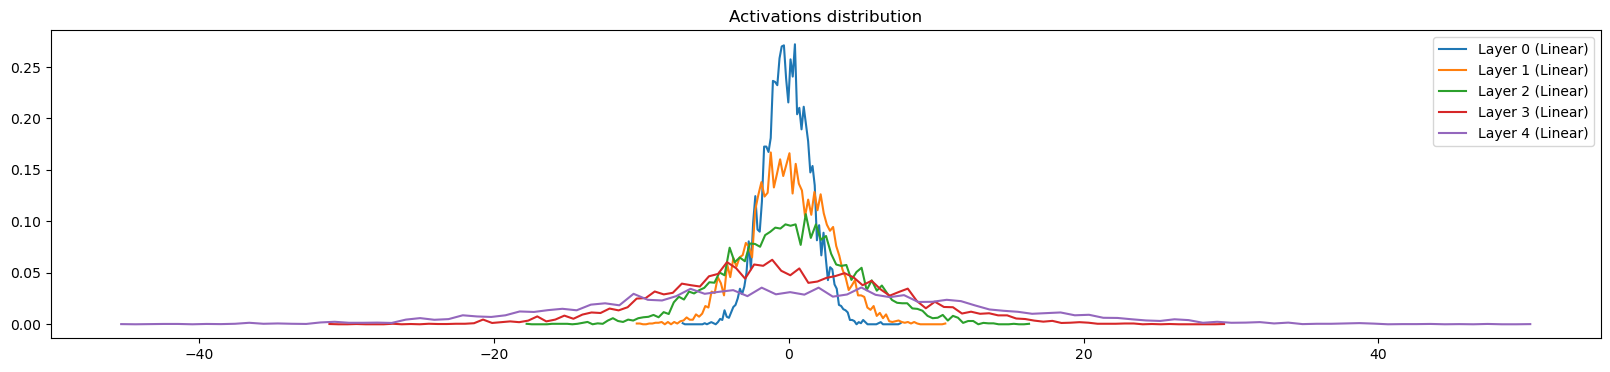

In [48]:
plt.figure(figsize=(20,4))
legends = []

for i, layer in enumerate(layers[:-1]): #note: exclude the output layer
    if isinstance(layer, Linear):
        t = layer.out # the output of the tanh
        print(f"Layer {i} tanh mean: {t.mean().item():.2f}, std: {t.std().item():.2f}")
        hy, hx = torch.histogram(t, density=True) # get the histogram of the tanh output, hx is the bin edges, and hy is the bin values
        plt.plot(hx[:-1].detach(), hy.detach()) 
        legends.append(f"Layer {i} ({layer.__class__.__name__})")

plt.legend(legends)
plt.title("Activations distribution")

- we notice that the activations start with some distribution and it gets expanded out (the std gets larger as we go from layer 1 to 6, and the distribution is not preserved)
    - mine: that is the exploding activations problem (the activations are getting larger and larger)

Layer 0 tanh mean: -0.00, std: 0.001726
Layer 1 tanh mean: -0.00, std: 0.001022
Layer 2 tanh mean: 0.00, std: 0.000618
Layer 3 tanh mean: -0.00, std: 0.000380
Layer 4 tanh mean: 0.00, std: 0.000223


Text(0.5, 1.0, 'Gradients distribution')

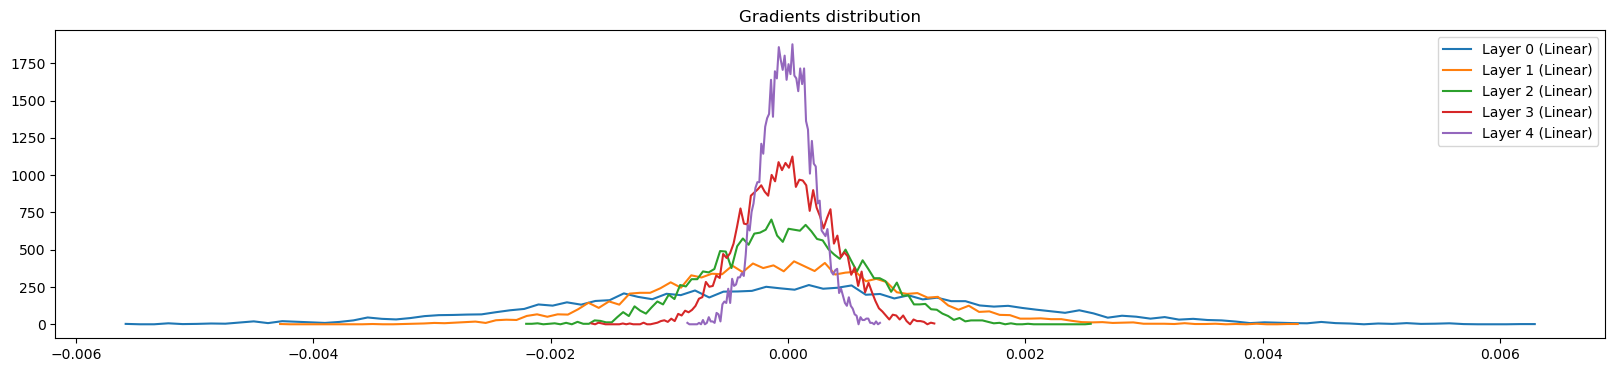

In [50]:
plt.figure(figsize=(20,4))
legends = []

for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
    if isinstance(layer, Linear):
        t = layer.out.grad # the output of the tanh
        print(f"Layer {i} tanh mean: {t.mean().item():.2f}, std: {t.std().item():.6f}")
        hy, hx = torch.histogram(t, density=True) # get the histogram of the tanh output, hx is the bin edges, and hy is the bin values
        plt.plot(hx[:-1].detach(), hy.detach()) 
        legends.append(f"Layer {i} ({layer.__class__.__name__})")

plt.legend(legends)
plt.title("Gradients distribution")

- as for the gradients distribution, (it is asymetric and not preserved as well), the std gets larger as we go from layer 6 to 1
    
- mine: so the when activations explode as we go from layer 1 to 6, the gradients will explode as we go from layer 6 to 1 (because the gradients are the backpropagated activations), and that is the exploding gradients problem

#### Case 2: smaller gain (activations get smaller and smaller)

In [53]:
n_embed = 10 # dimension of the embedding vectors
n_hidden = 200 # number of hidden units
g = torch.Generator().manual_seed(2147483647)


C = torch.randn((vocab_size, n_embed) , generator=g)

# first the model with no batch norm
layers = [
    Linear(n_embed * block_size, n_hidden), #Tanh(), 
    Linear(n_hidden, n_hidden), #Tanh(),
    Linear(n_hidden, n_hidden), #Tanh(),
    Linear(n_hidden, n_hidden), #Tanh(),
    Linear(n_hidden, n_hidden), #Tanh(),
    Linear(n_hidden, vocab_size)
]

# weight initialization (we already adjusted the weights, and now remains the gain)
with torch.no_grad():
    # multiply the hidden weights before the tanh by 5/3 (gain)
    layers[-1].weight *= 0.1 # make last layer less confident
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= 0.5 # smaller gain that what should be for linear layers (which is 1)

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.numel() for p in parameters))

for p in parameters:
    p.requires_grad = True

172697


In [54]:
steps = 200000
batch_size = 32
lossi = []

for i in range(steps):
    idx = torch.randint(0, x_train.shape[0], (batch_size,), generator=g)
    # Forward pass
    emb = C[x_train[idx]]
    x = emb.view(-1, block_size * n_embed)
    for layer in layers:
        x = layer(x)

    # Compute loss
    loss = F.cross_entropy(x, y_train[idx])


    ## Visualization purposes: Retain output gradients
    for layer in layers:
        layer.out.retain_grad()

    # Backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # step learning rate decay
    lr = 0.1 if i < 100000 else 0.01

    # Update the parameters
    for p in parameters:
        p.data -= p.grad * lr
    
    # track stats
    if i % 10000 == 0:
        print(f"Step {i/steps*100:.2f}%", loss.item())
    lossi.append(loss.log10().item())

    break

Step 0.00% 3.2959020137786865


Layer 0 tanh mean: -0.01, std: 0.49
Layer 1 tanh mean: -0.00, std: 0.24
Layer 2 tanh mean: -0.00, std: 0.12
Layer 3 tanh mean: -0.00, std: 0.06
Layer 4 tanh mean: -0.00, std: 0.03


Text(0.5, 1.0, 'Activations distribution')

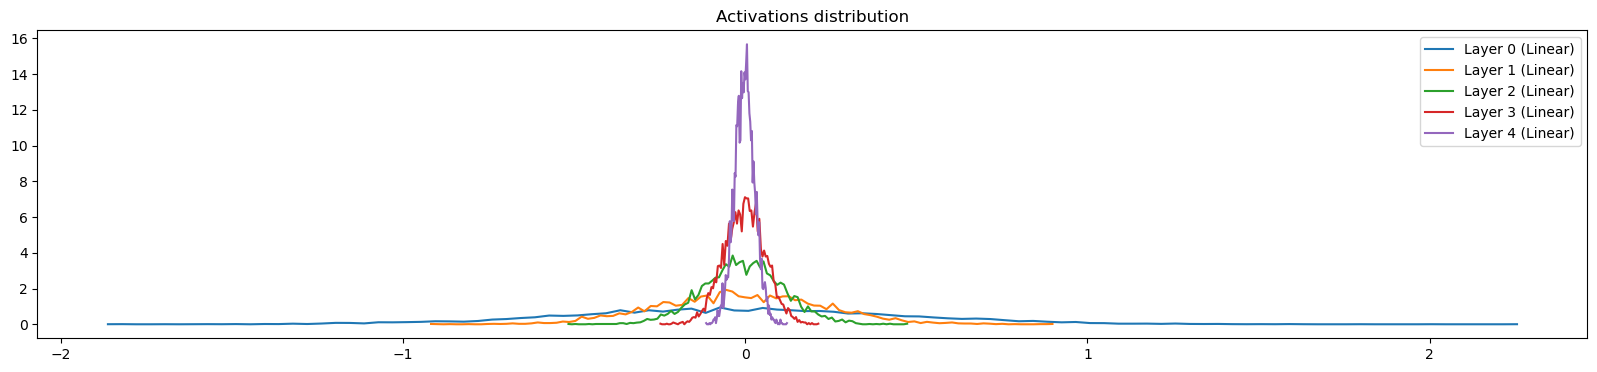

In [55]:
plt.figure(figsize=(20,4))
legends = []

for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
    if isinstance(layer, Linear):
        t = layer.out # the output of the tanh
        print(f"Layer {i} tanh mean: {t.mean().item():.2f}, std: {t.std().item():.2f}")
        hy, hx = torch.histogram(t, density=True) # get the histogram of the tanh output, hx is the bin edges, and hy is the bin values
        plt.plot(hx[:-1].detach(), hy.detach()) 
        legends.append(f"Layer {i} ({layer.__class__.__name__})")

plt.legend(legends)
plt.title("Activations distribution")

- mine: that is the vanishing gradients problem (as the activations get smaller and smaller as we go from layer 1 to 6 -notice the above distribution getting smaller or equivalently the std gets smallr-), we expect the gradients initial distribution to be smaller and smaller as we go from layer 6 to 1 as we will see below

Layer 0 tanh mean: 0.00, std: 0.000014
Layer 1 tanh mean: -0.00, std: 0.000026
Layer 2 tanh mean: 0.00, std: 0.000052
Layer 3 tanh mean: -0.00, std: 0.000106
Layer 4 tanh mean: 0.00, std: 0.000212


Text(0.5, 1.0, 'Gradients distribution')

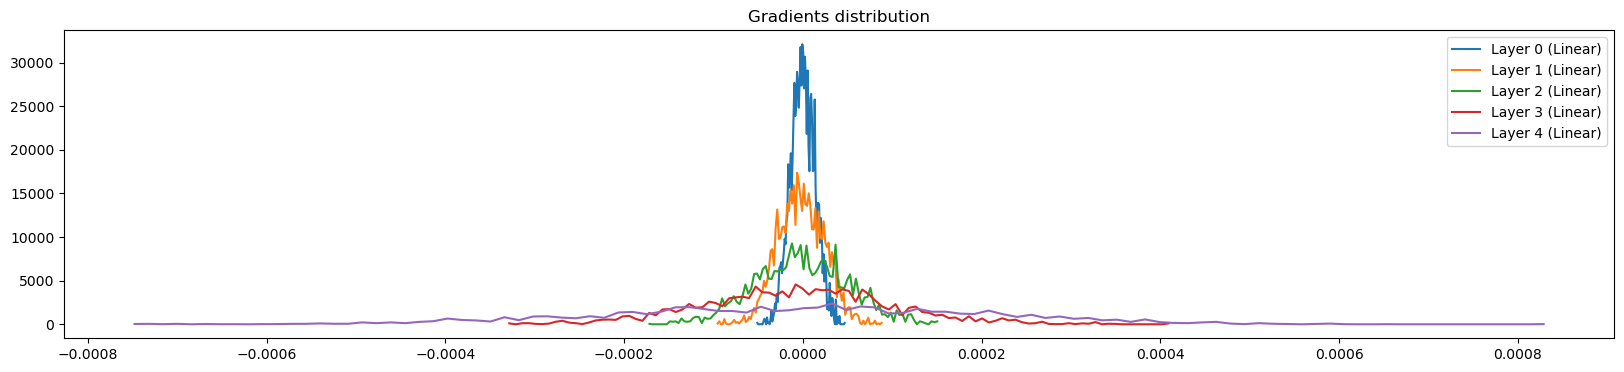

In [56]:
plt.figure(figsize=(20,4))
legends = []

for i, layer in enumerate(layers[:-1]):
    if isinstance(layer, Linear):
        t = layer.out.grad # the output of the tanh
        print(f"Layer {i} tanh mean: {t.mean().item():.2f}, std: {t.std().item():.6f}")
        hy, hx = torch.histogram(t, density=True) # get the histogram of the tanh output, hx is the bin edges, and hy is the bin values
        plt.plot(hx[:-1].detach(), hy.detach()) 
        legends.append(f"Layer {i} ({layer.__class__.__name__})")

plt.legend(legends)
plt.title("Gradients distribution")

- mine: notice that the gradients distribution is getting smaller and smaller as we go from layer 6 to 1 -we start with wide layer 6 distribution and that gets confined -smaller- as we go to layer 1 -in other words the std gets smaller as we go from 6 to 1- (that is the vanishing gradients problem)

- so, if the activations get smaller as we go deeper then the gradients will get smaller as we go back (vanishing gradients problem)
    - which makes sense because 

#### Case 3: perfect initialization (gain = 1)

In [114]:
n_embed = 10 # dimension of the embedding vectors
n_hidden = 200 # number of hidden units
g = torch.Generator().manual_seed(2147483647)


C = torch.randn((vocab_size, n_embed) , generator=g)

# first the model with no batch norm
layers = [
    Linear(n_embed * block_size, n_hidden), #Tanh(), 
    Linear(n_hidden, n_hidden), #Tanh(),
    Linear(n_hidden, n_hidden), #Tanh(),
    Linear(n_hidden, n_hidden), #Tanh(),
    Linear(n_hidden, n_hidden), #Tanh(),
    Linear(n_hidden, vocab_size)
]

# weight initialization (we already adjusted the weights, and now remains the gain)
with torch.no_grad():
    # multiply the hidden weight before the softmax with 
    layers[-1].weight *= 0.1
    # multiply the hidden weight
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= 1

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.numel() for p in parameters))

for p in parameters:
    p.requires_grad = True

172697


In [115]:
steps = 200000
batch_size = 32
lossi = []


for i in range(steps):
    idx = torch.randint(0, x_train.shape[0], (batch_size,), generator=g)
    # Forward pass
    emb = C[x_train[idx]]
    x = emb.view(-1, block_size * n_embed)
    for layer in layers:
        x = layer(x)

    # Compute loss
    loss = F.cross_entropy(x, y_train[idx])


    ## Visualization purposes: Retain output gradients
    for layer in layers:
        layer.out.retain_grad()

    # Backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # step learning rate decay
    lr = 0.1 if i < 100000 else 0.01

    # Update the parameters
    for p in parameters:
        p.data -= p.grad * lr
    
    # track stats
    if i % 10000 == 0:
        print(f"Step {i/steps*100:.2f}%", loss.item())
    lossi.append(loss.log10().item())

    break

Step 0.00% 3.301565170288086


Layer 0 tanh mean: 0.03, std: 0.98
Layer 1 tanh mean: 0.00, std: 1.00
Layer 2 tanh mean: -0.03, std: 1.00
Layer 3 tanh mean: 0.00, std: 0.98
Layer 4 tanh mean: -0.02, std: 1.01


Text(0.5, 1.0, 'Activations distribution')

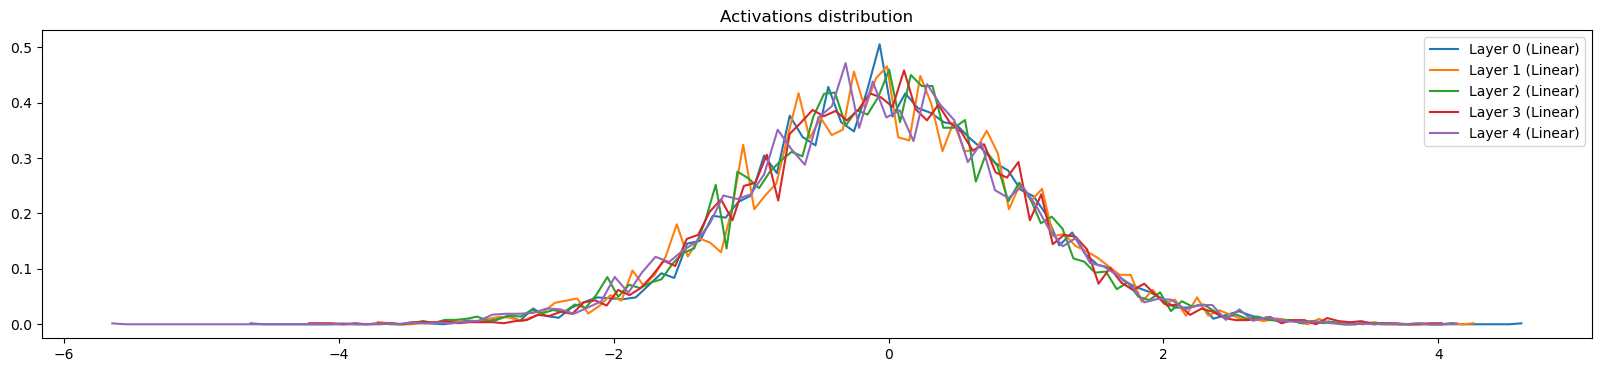

In [116]:
plt.figure(figsize=(20,4))
legends = []

for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
    if isinstance(layer, Linear):
        t = layer.out # the output of the tanh
        print(f"Layer {i} tanh mean: {t.mean().item():.2f}, std: {t.std().item():.2f}")
        hy, hx = torch.histogram(t, density=True) # get the histogram of the tanh output, hx is the bin edges, and hy is the bin values
        plt.plot(hx[:-1].detach(), hy.detach()) 
        legends.append(f"Layer {i} ({layer.__class__.__name__})")

plt.legend(legends)
plt.title("Activations distribution")

- the distribution of the activation is roughly the same (preseved) as we go from layer 1 to 6, so we will expect the gradients to be roughly preserved as well as we go from layer 6 to 1

- so this is what we want, if the activations are roughly preserved in the forward pass, then the gradients will be roughly preserved in the backward pass (and that way each layer will learn at the same rate, no matter how deep the network is)
    - `so the sign of a healthy neural network is the symmetry in the activations and gradients distributions`

Layer 0 tanh mean: -0.00, std: 0.000222
Layer 1 tanh mean: 0.00, std: 0.000221
Layer 2 tanh mean: 0.00, std: 0.000220
Layer 3 tanh mean: -0.00, std: 0.000221
Layer 4 tanh mean: -0.00, std: 0.000217


Text(0.5, 1.0, 'Gradients distribution')

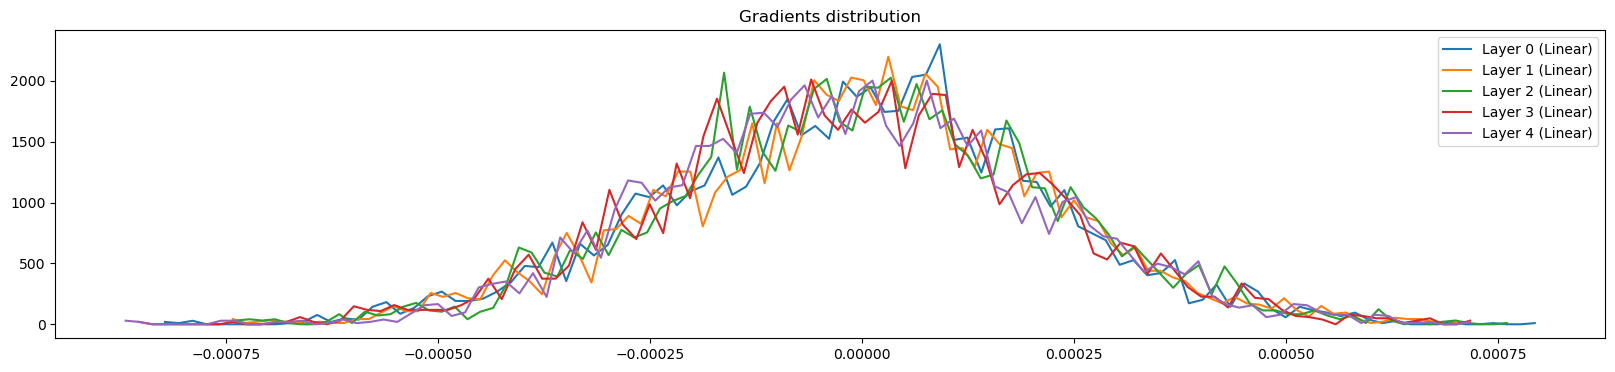

In [117]:
plt.figure(figsize=(20,4))
legends = []

for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
    if isinstance(layer, Linear):
        t = layer.out.grad # the output of the tanh
        print(f"Layer {i} tanh mean: {t.mean().item():.2f}, std: {t.std().item():.6f}")
        hy, hx = torch.histogram(t, density=True) # get the histogram of the tanh output, hx is the bin edges, and hy is the bin values
        plt.plot(hx[:-1].detach(), hy.detach()) 
        legends.append(f"Layer {i} ({layer.__class__.__name__})")

plt.legend(legends)
plt.title("Gradients distribution")

### example 2: linear layers with Tanh Activations
- a healthy neural network in here is to multiply the weights by $\frac{1}{\sqrt{n_{inputs}}}$ to compensate for the weights multiplication, and multiply by 5/3 gain to compensate for the tanh squashing the values to -1 and 1

#### Case1: proper gain

In [62]:
n_embed = 10 # dimension of the embedding vectors
n_hidden = 200 # number of hidden units
g = torch.Generator().manual_seed(2147483647)


C = torch.randn((vocab_size, n_embed) , generator=g)

# first the model with no batch norm
layers = [
    Linear(n_embed * block_size, n_hidden), Tanh(), 
    Linear(n_hidden, n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), Tanh(),
    Linear(n_hidden, vocab_size)
]

# weight initialization (we already adjusted the weights, and now remains the gain)
with torch.no_grad():
    # make last layer less confident
    layers[-1].weight *= 0.1
    # multiply the hidden weights before the tanh by 5/3 (gain)
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= (5/3)

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.numel() for p in parameters))

for p in parameters:
    p.requires_grad = True

172697


In [63]:
steps = 200000
batch_size = 32
lossi = []

for i in range(steps):
    idx = torch.randint(0, x_train.shape[0], (batch_size,), generator=g)
    # Forward pass
    emb = C[x_train[idx]]
    x = emb.view(-1, block_size * n_embed)
    for layer in layers:
        x = layer(x)

    # Compute loss
    loss = F.cross_entropy(x, y_train[idx])


    ## Visualization purposes: Retain output gradients
    for layer in layers:
        layer.out.retain_grad()

    # Backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # step learning rate decay
    lr = 0.1 if i < 100000 else 0.01

    # Update the parameters
    for p in parameters:
        p.data -= p.grad * lr
    
    # track stats
    if i % 10000 == 0:
        print(f"Step {i/steps*100:.2f}%", loss.item())
    lossi.append(loss.log10().item())

    break

Step 0.00% 3.303291082382202


- now let's visualize the histograms of the activations and gradients at the beginning

Layer 1 tanh mean: 0.01, std: 0.75, Saturation: 19.09%
Layer 3 tanh mean: 0.00, std: 0.69, Saturation: 10.19%
Layer 5 tanh mean: -0.01, std: 0.66, Saturation: 7.28%
Layer 7 tanh mean: 0.02, std: 0.65, Saturation: 5.52%
Layer 9 tanh mean: 0.03, std: 0.65, Saturation: 6.09%


Text(0.5, 1.0, 'Activations distribution')

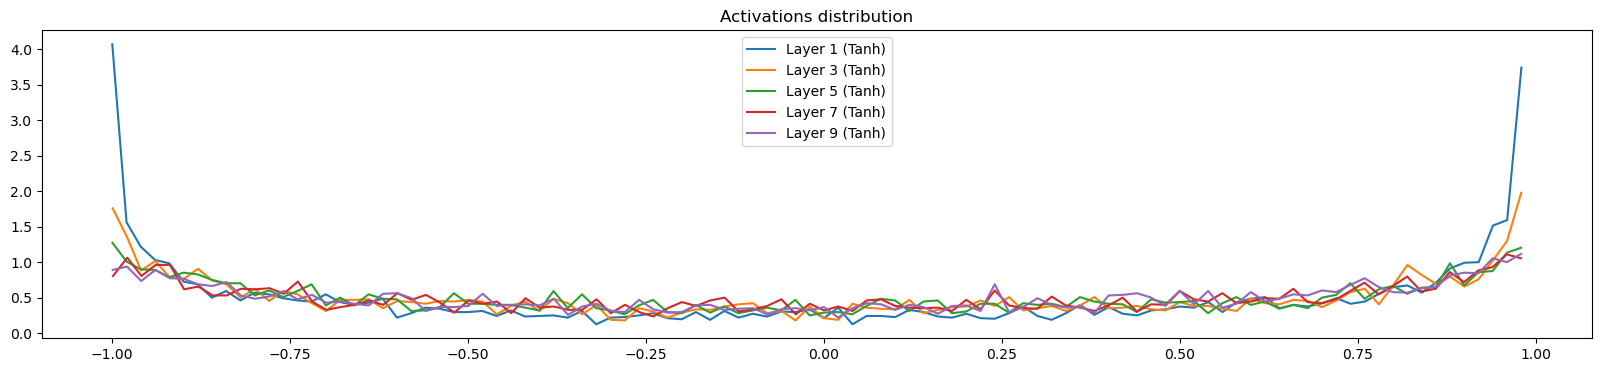

In [64]:
plt.figure(figsize=(20,4))
legends = []

for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
    if isinstance(layer, Tanh):
        t = layer.out # the output of the tanh
        print(f"Layer {i} tanh mean: {t.mean().item():.2f}, std: {t.std().item():.2f}, Saturation: {(t.abs() > 0.97).float().mean().item()*100:.2f}%")
        hy, hx = torch.histogram(t, density=True) # get the histogram of the tanh output, hx is the bin edges, and hy is the bin values
        plt.plot(hx[:-1].detach(), hy.detach()) 
        legends.append(f"Layer {i} ({layer.__class__.__name__})")

plt.legend(legends)
plt.title("Activations distribution")

- notice that the first layer has fair percentage of saturated neurons for the batch, but for the rest of layers are sort of stable (stable std, mean, and saturation percentage)
    - that is because of the weights initialization (we multiplied the weights by $\frac{1}{\sqrt{n_{inputs}}}$ to compensate for the weights multiplication, and then multiplied by 5/3 gain to compensate for the tanh squashing)
- so, we expect the gradients to be well-behaved as well

Layer 1 tanh mean: 0.00, std: 0.000296
Layer 3 tanh mean: -0.00, std: 0.000280
Layer 5 tanh mean: 0.00, std: 0.000261
Layer 7 tanh mean: -0.00, std: 0.000237
Layer 9 tanh mean: 0.00, std: 0.000218


Text(0.5, 1.0, 'Gradients distribution')

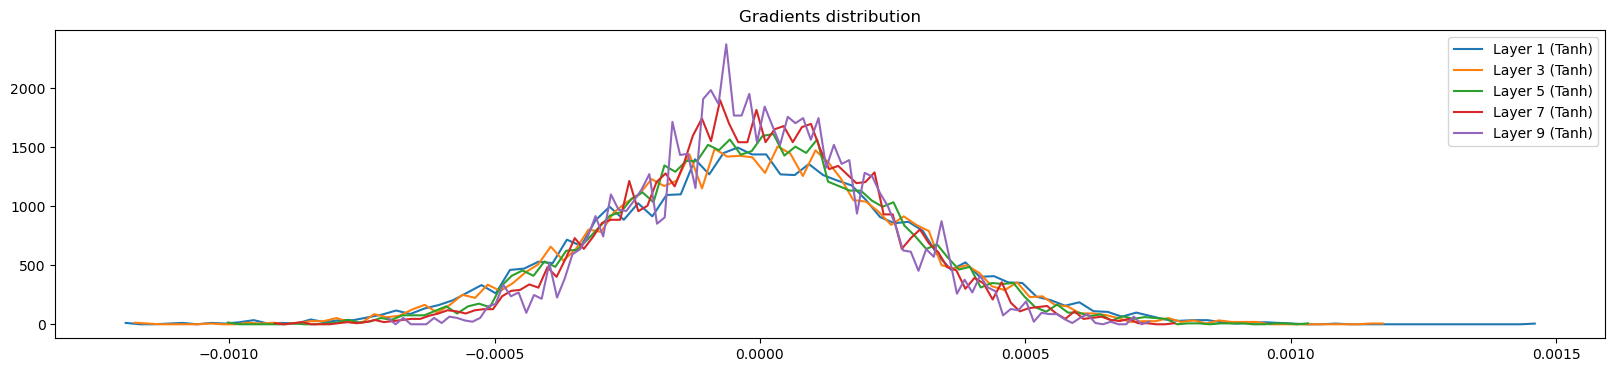

In [65]:
plt.figure(figsize=(20,4))
legends = []

for i, layer in enumerate(layers):
    if isinstance(layer, Tanh):
        t = layer.out.grad # the output of the tanh
        print(f"Layer {i} tanh mean: {t.mean().item():.2f}, std: {t.std().item():.6f}")
        hy, hx = torch.histogram(t, density=True) # get the histogram of the tanh output, hx is the bin edges, and hy is the bin values
        plt.plot(hx[:-1].detach(), hy.detach()) 
        legends.append(f"Layer {i} ({layer.__class__.__name__})")

plt.legend(legends)
plt.title("Gradients distribution")

- all the different layers, have roughly the same gradients (they are not vanishing or exploding), and they are indeed well-behaved

#### case2: Ignoring the gain multiplication (lower gain)
- what happens if we don't multiply the weights by the gain (5/3 for tanh) in the initialization (we still multiply by $\frac{1}{\sqrt{n_{inputs}}}$ to compensate for the weights multiplication)
    - we will see that the activations will shrink (the std will get smaller (because of the squashing of the tanh), and since the distribution std will shrink, more values will be around 0 (like if we have no nonlinearity), and therefore we will see that the saturation percentage will approach 0 below 

In [72]:
n_embed = 10 # dimension of the embedding vectors
n_hidden = 200 # number of hidden units
g = torch.Generator().manual_seed(2147483647)


C = torch.randn((vocab_size, n_embed) , generator=g)

# first the model with no batch norm
layers = [
    Linear(n_embed * block_size, n_hidden), Tanh(), 
    Linear(n_hidden, n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), Tanh(),
    Linear(n_hidden, vocab_size)
]

# weight initialization (we already adjusted the weights, and now remains the gain)
with torch.no_grad():
    # make last layer less confident
    layers[-1].weight *= 0.1
    # multiply the hidden weights before the tanh by 5/3 (gain)
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= 1 #(5/3)

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.numel() for p in parameters))

for p in parameters:
    p.requires_grad = True

172697


In [73]:
steps = 200000
batch_size = 32
lossi = []

for i in range(steps):
    idx = torch.randint(0, x_train.shape[0], (batch_size,), generator=g)
    # Forward pass
    emb = C[x_train[idx]]
    x = emb.view(-1, block_size * n_embed)
    for layer in layers:
        x = layer(x)

    # Compute loss
    loss = F.cross_entropy(x, y_train[idx])


    ## Visualization purposes: Retain output gradients
    for layer in layers:
        layer.out.retain_grad()

    # Backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # step learning rate decay
    lr = 0.1 if i < 100000 else 0.01

    # Update the parameters
    for p in parameters:
        p.data -= p.grad * lr
    
    # track stats
    if i % 10000 == 0:
        print(f"Step {i/steps*100:.2f}%", loss.item())
    lossi.append(loss.log10().item())

    break

Step 0.00% 3.2924880981445312


Layer 1 tanh mean: 0.01, std: 0.62, Saturation: 3.44%
Layer 3 tanh mean: 0.01, std: 0.48, Saturation: 0.03%
Layer 5 tanh mean: -0.01, std: 0.40, Saturation: 0.00%
Layer 7 tanh mean: 0.00, std: 0.35, Saturation: 0.00%
Layer 9 tanh mean: 0.01, std: 0.32, Saturation: 0.00%


Text(0.5, 1.0, 'Activations distribution')

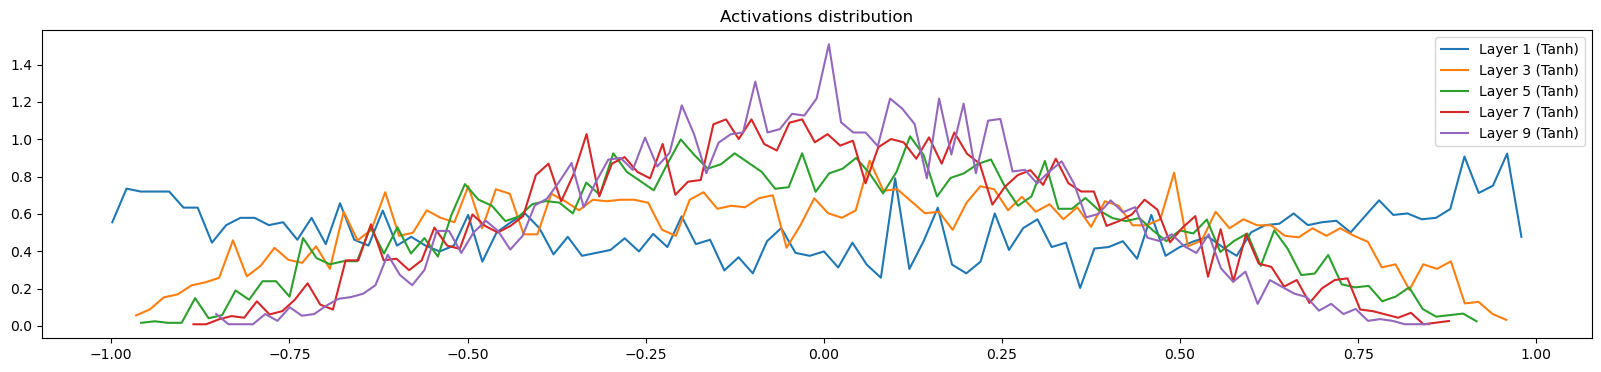

In [74]:
plt.figure(figsize=(20,4))
legends = []

for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
    if isinstance(layer, Tanh):
        t = layer.out # the output of the tanh
        print(f"Layer {i} tanh mean: {t.mean().item():.2f}, std: {t.std().item():.2f}, Saturation: {(t.abs() > 0.97).float().mean().item()*100:.2f}%")
        hy, hx = torch.histogram(t, density=True) # get the histogram of the tanh output, hx is the bin edges, and hy is the bin values
        plt.plot(hx[:-1].detach(), hy.detach()) 
        legends.append(f"Layer {i} ({layer.__class__.__name__})")

plt.legend(legends)
plt.title("Activations distribution")

- all what we did is to ignore the gain (we multiplied the weights by $\frac{1}{\sqrt{n_{inputs}}}$ to compensate for the weights multiplication, but we didn't multiply by 5/3 to compensate for the tanh squashing), and we see that deep networks are not that forgiving to our initialization
- so we indeed see that the activations are slightly shrinking (std getting smaller as we go from layer 1 to 9) (Asymetry), so we expect the gradients to be Asymetric as well (mine: vanishing as we go from layer 9 to 1)

Layer 1 tanh mean: 0.00, std: 0.000118
Layer 3 tanh mean: -0.00, std: 0.000147
Layer 5 tanh mean: -0.00, std: 0.000172
Layer 7 tanh mean: -0.00, std: 0.000192
Layer 9 tanh mean: 0.00, std: 0.000217


Text(0.5, 1.0, 'Gradients distribution')

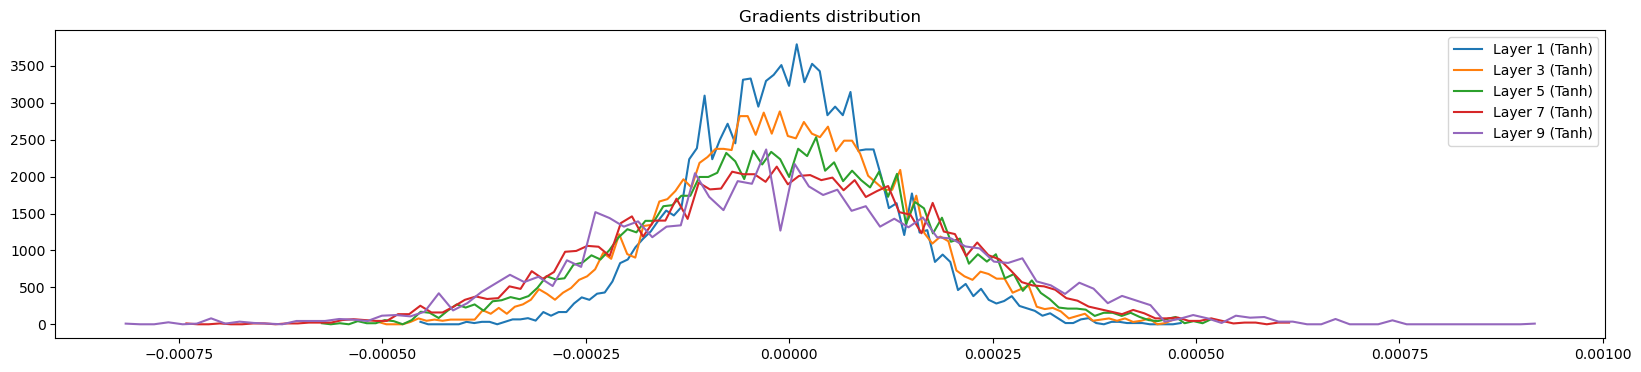

In [75]:
plt.figure(figsize=(20,4))
legends = []

for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
    if isinstance(layer, Tanh):
        t = layer.out.grad # the output of the tanh
        print(f"Layer {i} tanh mean: {t.mean().item():.2f}, std: {t.std().item():.6f}")
        hy, hx = torch.histogram(t, density=True) # get the histogram of the tanh output, hx is the bin edges, and hy is the bin values
        plt.plot(hx[:-1].detach(), hy.detach()) 
        legends.append(f"Layer {i} ({layer.__class__.__name__})")

plt.legend(legends)
plt.title("Gradients distribution")

- mine: we notice that the gradients started with some distribution then vanished as we go from layer 9 to 1 (the std gets smaller as we go from layer 9 to 1)
- mine: the lower gain case here is similar to the linear layer case with smaller gain, because the small activations will see the tanh as a linear function, that is why i managed to interpret the results

#### case3: Using too much gain
- what if we multiplied with a larger gain than what the activation function will squash?

In [76]:
n_embed = 10 # dimension of the embedding vectors
n_hidden = 200 # number of hidden units
g = torch.Generator().manual_seed(2147483647)


C = torch.randn((vocab_size, n_embed) , generator=g)

# first the model with no batch norm
layers = [
    Linear(n_embed * block_size, n_hidden), Tanh(), 
    Linear(n_hidden, n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), Tanh(),
    Linear(n_hidden, vocab_size)
]

# weight initialization (we already adjusted the weights, and now remains the gain)
with torch.no_grad():
    # make last layer less confident
    layers[-1].weight *= 0.1
    # multiply the hidden weights before the tanh by 5/3 (gain)
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= 5 #(5/3)

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.numel() for p in parameters))

for p in parameters:
    p.requires_grad = True

172697


In [77]:
steps = 200000
batch_size = 32
lossi = []

for i in range(steps):
    idx = torch.randint(0, x_train.shape[0], (batch_size,), generator=g)
    # Forward pass
    emb = C[x_train[idx]]
    x = emb.view(-1, block_size * n_embed)
    for layer in layers:
        x = layer(x)

    # Compute loss
    loss = F.cross_entropy(x, y_train[idx])


    ## Visualization purposes: Retain output gradients
    for layer in layers:
        layer.out.retain_grad()

    # Backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # step learning rate decay
    lr = 0.1 if i < 100000 else 0.01

    # Update the parameters
    for p in parameters:
        p.data -= p.grad * lr
    
    # track stats
    if i % 10000 == 0:
        print(f"Step {i/steps*100:.2f}%", loss.item())
    lossi.append(loss.log10().item())

    break

Step 0.00% 3.324862003326416


Layer 1 tanh mean: -0.00, std: 0.91, Saturation: 67.03%
Layer 3 tanh mean: -0.01, std: 0.91, Saturation: 63.70%
Layer 5 tanh mean: 0.01, std: 0.91, Saturation: 63.95%
Layer 7 tanh mean: 0.02, std: 0.91, Saturation: 64.45%
Layer 9 tanh mean: 0.00, std: 0.91, Saturation: 64.45%


Text(0.5, 1.0, 'Activations distribution')

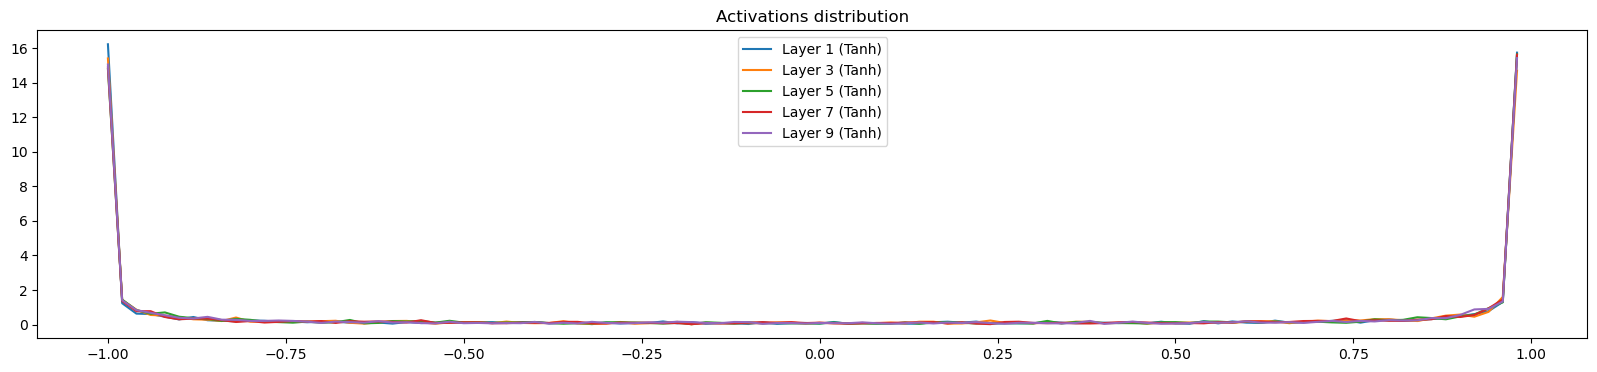

In [78]:
plt.figure(figsize=(20,4))
legends = []

for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
    if isinstance(layer, Tanh):
        t = layer.out # the output of the tanh
        print(f"Layer {i} tanh mean: {t.mean().item():.2f}, std: {t.std().item():.2f}, Saturation: {(t.abs() > 0.97).float().mean().item()*100:.2f}%")
        hy, hx = torch.histogram(t, density=True) # get the histogram of the tanh output, hx is the bin edges, and hy is the bin values
        plt.plot(hx[:-1].detach(), hy.detach()) 
        legends.append(f"Layer {i} ({layer.__class__.__name__})")

plt.legend(legends)
plt.title("Activations distribution")

- we notice that if we boosted the logits more than we should, the saturation percentage will increase

Layer 1 tanh mean: -0.00, std: 0.001748
Layer 3 tanh mean: 0.00, std: 0.001043
Layer 5 tanh mean: 0.00, std: 0.000623
Layer 7 tanh mean: -0.00, std: 0.000358
Layer 9 tanh mean: 0.00, std: 0.000217


Text(0.5, 1.0, 'Gradients distribution')

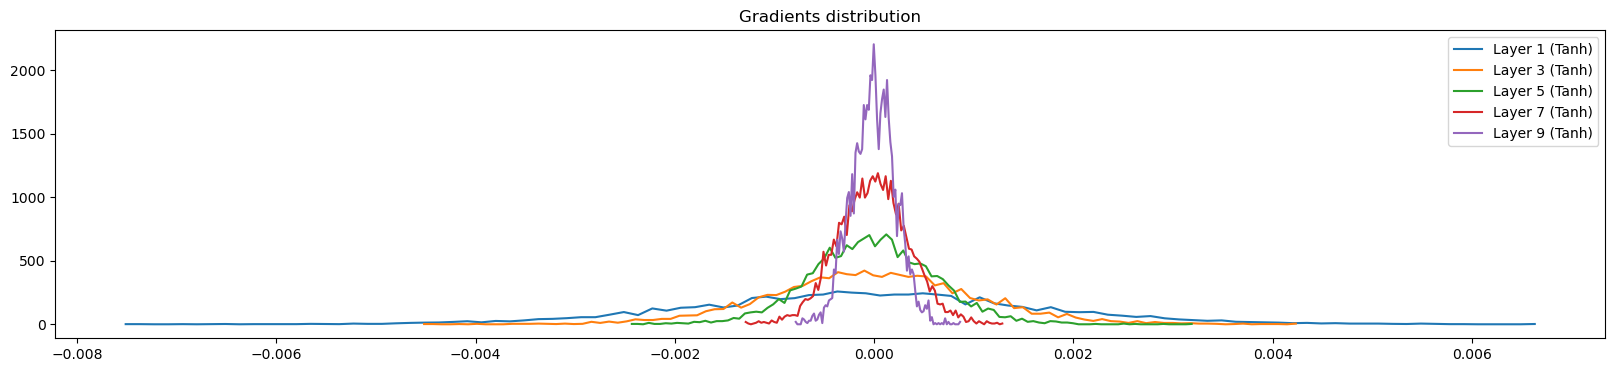

In [79]:
plt.figure(figsize=(20,4))
legends = []

for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
    if isinstance(layer, Tanh):
        t = layer.out.grad # the output of the tanh
        print(f"Layer {i} tanh mean: {t.mean().item():.2f}, std: {t.std().item():.6f}")
        hy, hx = torch.histogram(t, density=True) # get the histogram of the tanh output, hx is the bin edges, and hy is the bin values
        plt.plot(hx[:-1].detach(), hy.detach()) 
        legends.append(f"Layer {i} ({layer.__class__.__name__})")

plt.legend(legends)
plt.title("Gradients distribution")

- there is some asymmetry in the gradients and the distribution is not preserved

- mine: I managed to interpret the visualizations of the linear case (vanishing and exploding gradients) and also the tanh with smaller gain, but I didn't manage to interpret the tanh with larger gain for now, but all we need to know is that if the distribution is not preserved like above -the std gets larger as we go from layer 9 to 1- then we have a problem

- so, getting neural networks to train before these normalization layers and before advanced optimizers, and residual connections and so on, was extremely tedious (exact methematical initialization was crucial), we have to make sure that everything is precisly orchestrated and we have to care about the activations and gradients distributions

## More Visualizations
- we will visualize something also as important which is the gradient to weight ratio (the ratio of the gradients to the weights), and more importantly the update (gradient * learning rate) to the weights ratio (the ratio of the update to the weights)

- the purpose of these ratios is to see what is the scale of the update compared to the weights, and how much the weights will change in the next step
    - if the updates are much larger than the weights, then we would be in trouble (the weights will change too much in the next step)

### update to weight ratio in case of proper initialization

In [131]:
n_embed = 10 # dimension of the embedding vectors
n_hidden = 200 # number of hidden units
g = torch.Generator().manual_seed(2147483647)


C = torch.randn((vocab_size, n_embed) , generator=g)

# first the model with no batch norm
layers = [
    Linear(n_embed * block_size, n_hidden), Tanh(), 
    Linear(n_hidden, n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), Tanh(),
    Linear(n_hidden, vocab_size)
]

# weight initialization (we already adjusted the weights, and now remains the gain)
with torch.no_grad():
    # make last layer less confident
    layers[-1].weight *= 0.1
    # multiply the hidden weights before the tanh by 5/3 (gain)
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= (5/3)

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.numel() for p in parameters))

for p in parameters:
    p.requires_grad = True

172697


In [132]:
steps = 200000
batch_size = 32
lossi = []

for i in range(steps):
    idx = torch.randint(0, x_train.shape[0], (batch_size,), generator=g)
    # Forward pass
    emb = C[x_train[idx]]
    x = emb.view(-1, block_size * n_embed)
    for layer in layers:
        x = layer(x)

    # Compute loss
    loss = F.cross_entropy(x, y_train[idx])


    ## Visualization purposes: Retain output gradients
    for layer in layers:
        layer.out.retain_grad()

    # Backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # step learning rate decay
    lr = 0.1 if i < 100000 else 0.01

    # Update the parameters
    for p in parameters:
        p.data -= p.grad * lr
    
    # track stats
    if i % 10000 == 0:
        print(f"Step {i/steps*100:.2f}%", loss.item())
    lossi.append(loss.log10().item())

    break

Step 0.00% 3.300624370574951


weight torch.Size([27, 10])  |  mean: 0.00, std: 0.0014,  grad:data ratio: 0.001030
weight torch.Size([30, 200])  |  mean: 0.00, std: 0.0009,  grad:data ratio: 0.002750
weight torch.Size([200, 200])  |  mean: 0.00, std: 0.0007,  grad:data ratio: 0.006183
weight torch.Size([200, 200])  |  mean: -0.00, std: 0.0007,  grad:data ratio: 0.005455
weight torch.Size([200, 200])  |  mean: -0.00, std: 0.0006,  grad:data ratio: 0.004948
weight torch.Size([200, 200])  |  mean: -0.00, std: 0.0006,  grad:data ratio: 0.004625
weight torch.Size([200, 27])  |  mean: 0.00, std: 0.0237,  grad:data ratio: 2.724741


Text(0.5, 1.0, 'Gradients distribution')

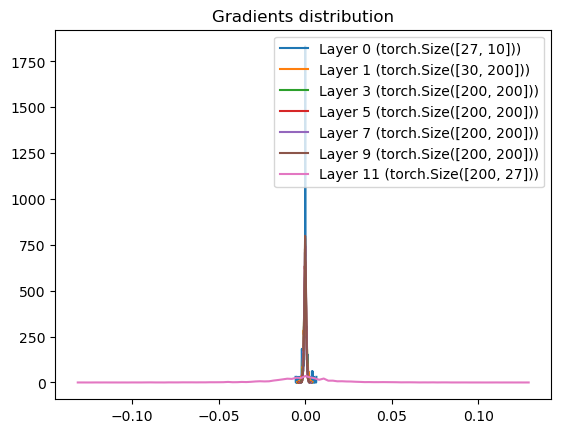

In [133]:
plt.Figure(figsize=(20,4))
legends = []
for i, p in enumerate(parameters):
    t = p.grad
    if p.ndim == 2:
        print(f"weight {p.shape}  |  mean: {t.mean().item():.2f}, std: {t.std().item():.4f},  grad:data ratio: {t.abs().mean().item()/(p.abs().mean() + 1e-5):.6f}")
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f"Layer {i} ({p.shape})")

plt.legend(legends)
plt.title("Gradients distribution")

- we notice that the gradients are 1000 smaller than the weights (ratio is around 0.001 to 0.006) which is good, except for the last layer (the gradient is actually 2 times larger than the weights)
    - and we can see that in the distribution, the gradients span larger range of values

- since the last layer gradients are greater, in the simple stochastic gradient descent we are using, the weights will be updated much much more than the other layers (we would be training the last layer much faster than the other layers at initialization)
    - if we train for a bit longer, the gradients will get smaller and kind of fixes itself

- let's see the update to weight ratio


In [134]:
steps = 200000
batch_size = 32
lossi = []
update_to_weight = []

for i in range(steps):
    idx = torch.randint(0, x_train.shape[0], (batch_size,), generator=g)
    # Forward pass
    emb = C[x_train[idx]]
    x = emb.view(-1, block_size * n_embed)
    for layer in layers:
        x = layer(x)

    # Compute loss
    loss = F.cross_entropy(x, y_train[idx])


    ## Visualization purposes: Retain output gradients
    for layer in layers:
        layer.out.retain_grad()

    # Backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # step learning rate decay
    lr = 0.1 if i < 100000 else 0.01

    # Update the parameters
    for p in parameters:
        p.data -= p.grad * lr
    
    # track stats
    if i % 10000 == 0:
        print(f"Step {i/steps*100:.2f}%", loss.item())
    lossi.append(loss.log10().item())

    with torch.no_grad():
        update_to_weight.append([(p.grad.std() * lr / p.data.std()).log10().item() for p in parameters]) 

    if i >= 1000:
        break

Step 0.00% 3.276378631591797


- we tookk the standard deviation of the update and divideed it by the standard deviation of the weights, and we did that for all the weights, then we took the log of that to be nicely visualized

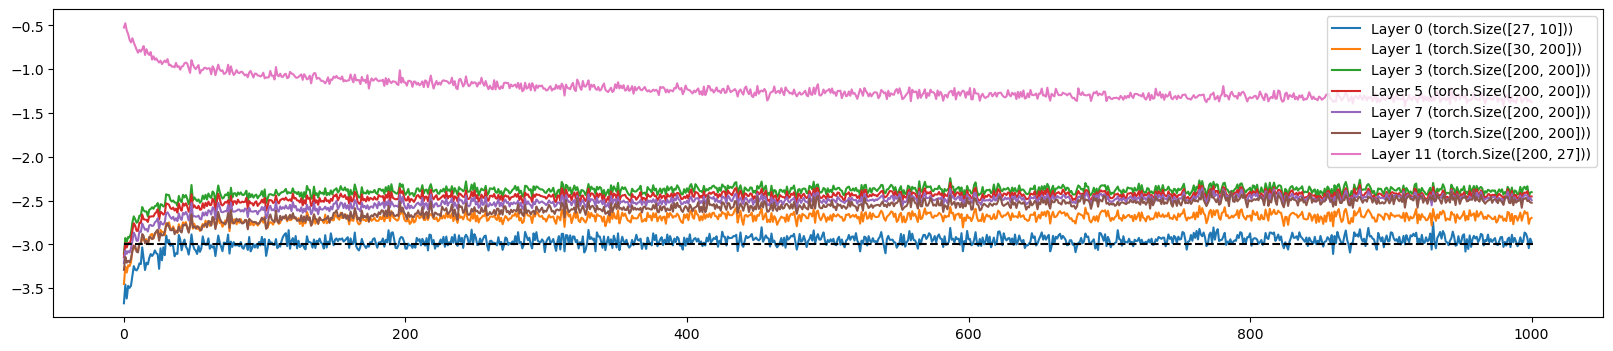

In [135]:
plt.figure(figsize=(20,4))
legends = []
for i, p in enumerate(parameters):
    if p.ndim == 2:
        t = p.grad
        plt.plot([update_to_weight[j][i] for j in range(len(update_to_weight))])
        legends.append(f"Layer {i} ({p.shape})")

plt.plot([0, len(update_to_weight)], [-3, -3], 'k--')
plt.legend(legends)

- we see that the updates evolve over time (during initialization they have certain values, and as we train, they stabilize)
    - it should be roughly around 1e-3 (0.001) -see the dashed line at -3 as we are plotting the exponents-, that means that updates to the weights should be around 0.1% of the weights (so the weights will change by 0.1% in the next step)

- and as expected the final layer is an outlier (it goes around 1e-1 (0.1) update to weight ratio), so the weights will change by 10% in the next step
    - and the reason for that is that this layer was artificially shrunk down to keep the softmax unconfident -we multiplied the weights by 0.1 to make it less confident in addition to the kaiming initialization- 
    - in other words, we made the values inside that tensor way too low, and that is why we get temporarily large updates then stailizes over time once it starts to learn

- we usually don't want these updates to be too much above 1e-3 (around -3 on the log plot)
    - if it is below 1e-3, then that means the parameters are not learning fast enough

### make the Learning Rate too slow and see the update to weight ratio

In [136]:
n_embed = 10 # dimension of the embedding vectors
n_hidden = 200 # number of hidden units
g = torch.Generator().manual_seed(2147483647)


C = torch.randn((vocab_size, n_embed) , generator=g)

# first the model with no batch norm
layers = [
    Linear(n_embed * block_size, n_hidden), Tanh(), 
    Linear(n_hidden, n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), Tanh(),
    Linear(n_hidden, vocab_size)
]

# weight initialization (we already adjusted the weights, and now remains the gain)
with torch.no_grad():
    # make last layer less confident
    layers[-1].weight *= 0.1
    # multiply the hidden weights before the tanh by 5/3 (gain)
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= (5/3)

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.numel() for p in parameters))

for p in parameters:
    p.requires_grad = True

172697


In [137]:
steps = 200000
batch_size = 32
lossi = []
update_to_weight = []

for i in range(steps):
    idx = torch.randint(0, x_train.shape[0], (batch_size,), generator=g)
    # Forward pass
    emb = C[x_train[idx]]
    x = emb.view(-1, block_size * n_embed)
    for layer in layers:
        x = layer(x)

    # Compute loss
    loss = F.cross_entropy(x, y_train[idx])


    ## Visualization purposes: Retain output gradients
    for layer in layers:
        layer.out.retain_grad()

    # Backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # step learning rate decay
    lr = 0.001

    # Update the parameters
    for p in parameters:
        p.data -= p.grad * lr
    
    # track stats
    if i % 10000 == 0:
        print(f"Step {i/steps*100:.2f}%", loss.item())
    lossi.append(loss.log10().item())

    with torch.no_grad():
        update_to_weight.append([(p.grad.std() * lr / p.data.std()).log10().item() for p in parameters]) 

    if i >= 1000:
        break

Step 0.00% 3.3221805095672607


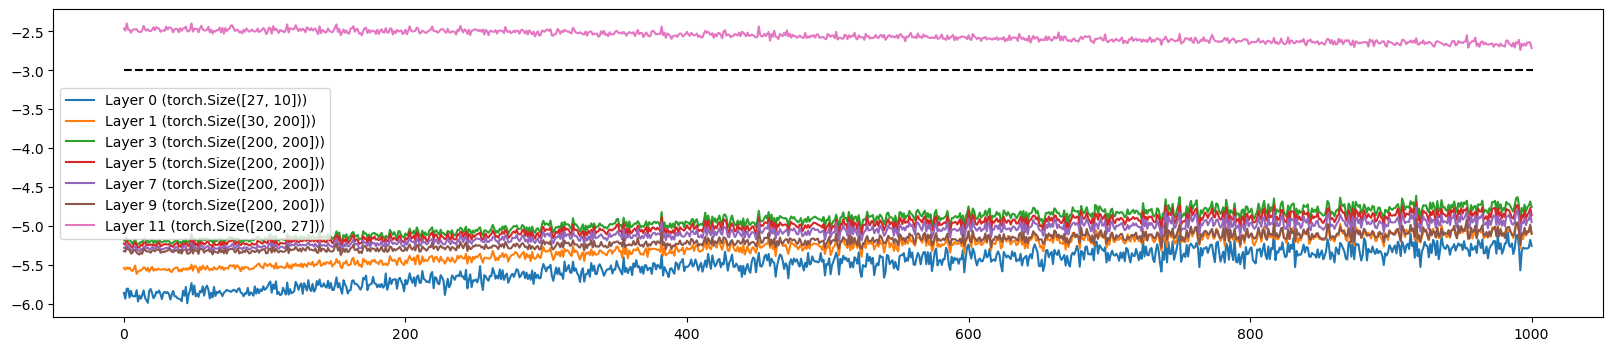

In [138]:
plt.figure(figsize=(20,4))
legends = []
for i, p in enumerate(parameters):
    if p.ndim == 2:
        t = p.grad
        plt.plot([update_to_weight[j][i] for j in range(len(update_to_weight))])
        legends.append(f"Layer {i} ({p.shape})")

plt.plot([0, len(update_to_weight)], [-3, -3], 'k--')
plt.legend(legends)

- see that the updates are way too small
- this is another way sometimes to set the learning rate and get a sense of what it should be 
- this visualization is not just for setting the learning rate, but also for debugging (assume that we forgot to scale the weights by $\frac{1}{\sqrt{n_{inputs}}}$, we already said that we will notice that on the activation and gradient distributions, but we will also notice that on the update to weight ratio)

- let's multiply by a 10 gain and let's don't make the final layer weights unconfident

In [145]:
n_embed = 10 # dimension of the embedding vectors
n_hidden = 200 # number of hidden units
g = torch.Generator().manual_seed(2147483647)


C = torch.randn((vocab_size, n_embed) , generator=g)

# first the model with no batch norm
layers = [
    Linear(n_embed * block_size, n_hidden), Tanh(), 
    Linear(n_hidden, n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), Tanh(),
    Linear(n_hidden, vocab_size)
]

# weight initialization (we already adjusted the weights, and now remains the gain)
with torch.no_grad():
    # make last layer less confident
    #layers[-1].weight *= 0.1
    # multiply the hidden weights before the tanh by 5/3 (gain)
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= (10)

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.numel() for p in parameters))

for p in parameters:
    p.requires_grad = True

172697


In [146]:
steps = 200000
batch_size = 32
lossi = []
update_to_weight = []

for i in range(steps):
    idx = torch.randint(0, x_train.shape[0], (batch_size,), generator=g)
    # Forward pass
    emb = C[x_train[idx]]
    x = emb.view(-1, block_size * n_embed)
    for layer in layers:
        x = layer(x)

    # Compute loss
    loss = F.cross_entropy(x, y_train[idx])


    ## Visualization purposes: Retain output gradients
    for layer in layers:
        layer.out.retain_grad()

    # Backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # step learning rate decay
    lr = 0.1 if i < 100000 else 0.01

    # Update the parameters
    for p in parameters:
        p.data -= p.grad * lr
    
    # track stats
    if i % 10000 == 0:
        print(f"Step {i/steps*100:.2f}%", loss.item())
    lossi.append(loss.log10().item())

    with torch.no_grad():
        update_to_weight.append([(p.grad.std() * lr / p.data.std()).log10().item() for p in parameters]) 

    if i >= 1000:
        break

Step 0.00% 3.598102569580078


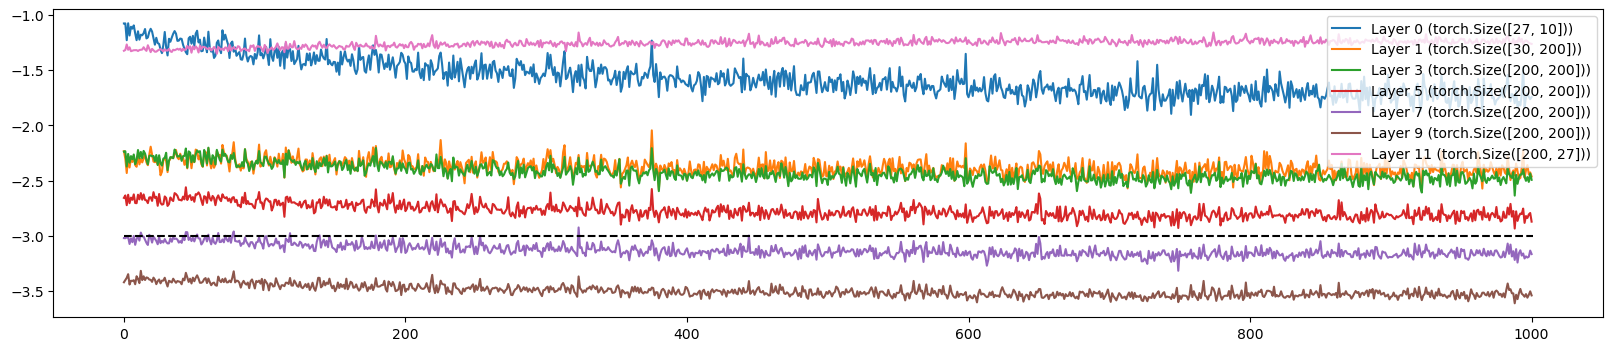

In [147]:
plt.figure(figsize=(20,4))
legends = []
for i, p in enumerate(parameters):
    if p.ndim == 2:
        t = p.grad
        plt.plot([update_to_weight[j][i] for j in range(len(update_to_weight))])
        legends.append(f"Layer {i} ({p.shape})")

plt.plot([0, len(update_to_weight)], [-3, -3], 'k--')
plt.legend(legends)

- we see a disparity in how fast these layers are learning (some of them are learning way too fast)
    - we should be around 1e-3 (around -3 on the log plot) up to -2.5 and down to -3.5
    - that is because they are receiving gradients of different distributions (because we are not calibrating the weights properly)

- recap: the above 3 visualizations will tell us if we made any calculation mistakes in the initialization of the neural network, and also to set the learning rate
    - the activations and gradients distributions (make sure they are symmetric)
    - the updates -gradient * learning rate- to weights ratio (make sure they are around 1e-3)



## Using a batchnorm

- so far we seen how to calibrate the weights -by multiplying them by $\frac{1}{\sqrt{n_{inputs}}}$ and calibrating activations -by multiplying them by a gain- and making the final layer unconfident -by multiplying the weights by 0.1- 

- but all of this feels like balancing a pencil on its tip, so let's use the batch norm to make things more stable

In [148]:
n_embed = 10 
n_hidden = 200 
g = torch.Generator().manual_seed(2147483647)


C = torch.randn((vocab_size, n_embed) , generator=g)

# first the model with no batch norm
layers = [
    Linear(n_embed * block_size, n_hidden), BatchNorm1d(n_hidden), Tanh(), 
    Linear(n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size), BatchNorm1d(vocab_size)
]

# weight initialization (we already adjusted the weights, and now remains the gain)
with torch.no_grad():
    # make gamma small to make the batch norm less confident
    layers[-1].gamma *= 0.1 
    # multiply the hidden weights before the tanh by 5/3 (gain)
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= (5/3)

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.numel() for p in parameters))

for p in parameters:
    p.requires_grad = True

174751


- we introduced batchnorm after all linear layers, and we also made the final layer -batch norm now- less confident by making gamma smaller -as it is the variable that interacts multiplicatively with the input-

In [149]:
steps = 200000
batch_size = 32
lossi = []
update_to_weight = []

for i in range(steps):
    idx = torch.randint(0, x_train.shape[0], (batch_size,), generator=g)
    # Forward pass
    emb = C[x_train[idx]]
    x = emb.view(-1, block_size * n_embed)
    for layer in layers:
        x = layer(x)

    # Compute loss
    loss = F.cross_entropy(x, y_train[idx])


    ## Visualization purposes: Retain output gradients
    for layer in layers:
        layer.out.retain_grad()

    # Backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # step learning rate decay
    lr = 0.1 if i < 100000 else 0.01

    # Update the parameters
    for p in parameters:
        p.data -= p.grad * lr
    
    # track stats
    if i % 10000 == 0:
        print(f"Step {i/steps*100:.2f}%", loss.item())
    lossi.append(loss.log10().item())

    with torch.no_grad():
        update_to_weight.append([(p.grad.std() * lr / p.data.std()).log10().item() for p in parameters]) 

    if i >= 1000:
        break

Step 0.00% 3.3139419555664062


### Visualizations

Layer 2 tanh mean: 0.00, std: 0.63, Saturation: 3.41%
Layer 5 tanh mean: -0.00, std: 0.64, Saturation: 2.78%
Layer 8 tanh mean: -0.00, std: 0.64, Saturation: 2.84%
Layer 11 tanh mean: -0.00, std: 0.65, Saturation: 2.33%
Layer 14 tanh mean: 0.00, std: 0.65, Saturation: 2.16%


Text(0.5, 1.0, 'Activations distribution')

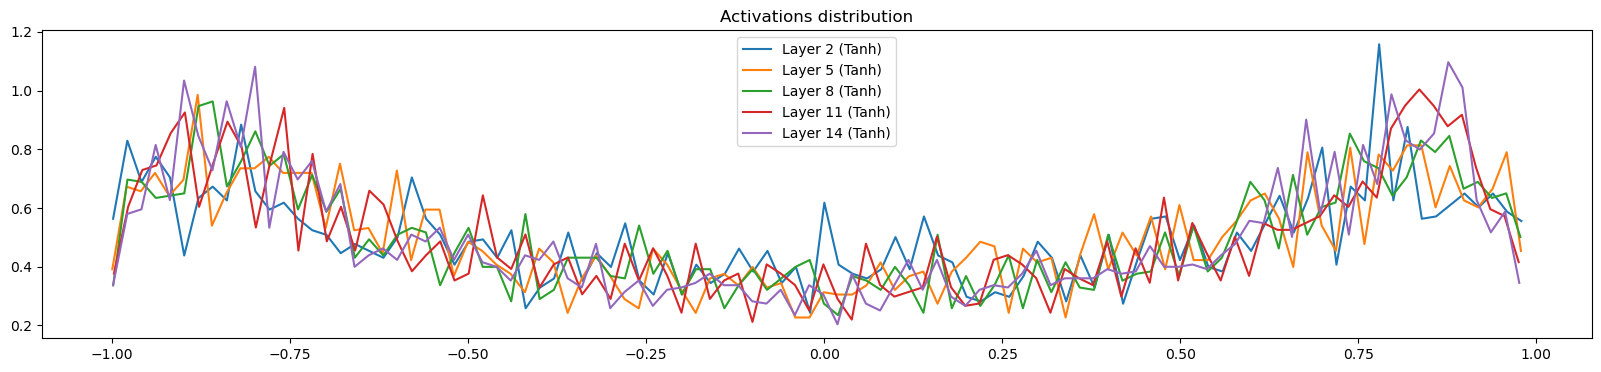

In [150]:
plt.figure(figsize=(20,4))
legends = []

for i, layer in enumerate(layers):
    if isinstance(layer, Tanh):
        t = layer.out # the output of the tanh
        print(f"Layer {i} tanh mean: {t.mean().item():.2f}, std: {t.std().item():.2f}, Saturation: {(t.abs() > 0.97).float().mean().item()*100:.2f}%")
        hy, hx = torch.histogram(t, density=True) # get the histogram of the tanh output, hx is the bin edges, and hy is the bin values
        plt.plot(hx[:-1].detach(), hy.detach()) 
        legends.append(f"Layer {i} ({layer.__class__.__name__})")

plt.legend(legends)
plt.title("Activations distribution")

- unsurprisingly, the activations are well-behaved and preserved (the std is roughly the same as we go from layer 1 to 9)
    - std is roughly at 0.65 for all layers
    - the saturation percentage is also roughly the same for all layers
- everything looks homogeneous and well-behaved

Layer 2 tanh mean: -0.00, std: 0.001951
Layer 5 tanh mean: 0.00, std: 0.001712
Layer 8 tanh mean: -0.00, std: 0.001559
Layer 11 tanh mean: 0.00, std: 0.001475
Layer 14 tanh mean: 0.00, std: 0.001443


Text(0.5, 1.0, 'Gradients distribution')

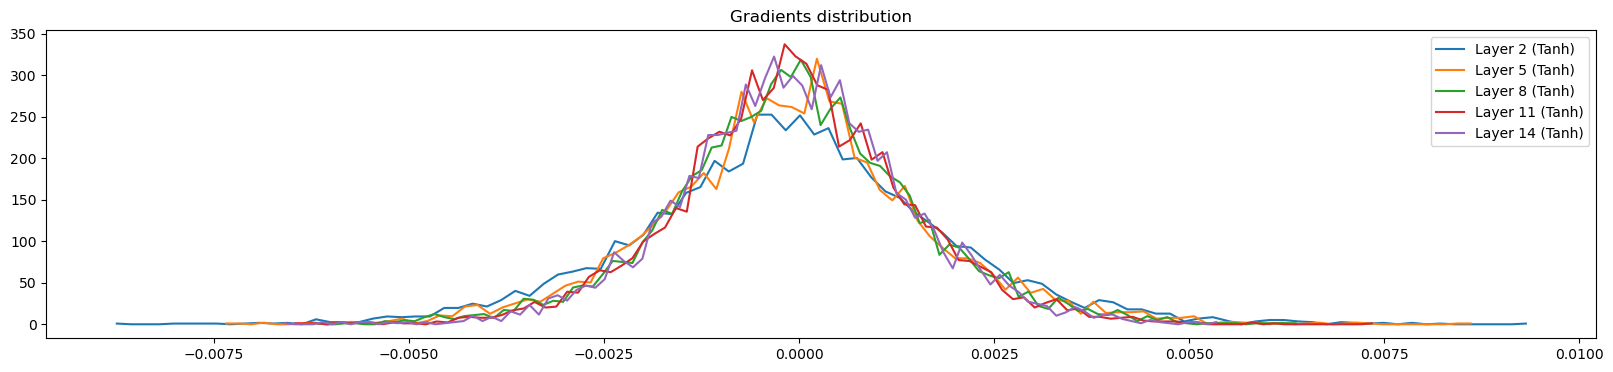

In [151]:
plt.figure(figsize=(20,4))
legends = []

for i, layer in enumerate(layers):
    if isinstance(layer, Tanh):
        t = layer.out.grad # the output of the tanh
        print(f"Layer {i} tanh mean: {t.mean().item():.2f}, std: {t.std().item():.6f}")
        hy, hx = torch.histogram(t, density=True) # get the histogram of the tanh output, hx is the bin edges, and hy is the bin values
        plt.plot(hx[:-1].detach(), hy.detach()) 
        legends.append(f"Layer {i} ({layer.__class__.__name__})")

plt.legend(legends)
plt.title("Gradients distribution")

- the gradients look wonderful as well, they are well-behaved and preserved as we go from layer 9 to 1
    - the std is roughly the same as well as the mean

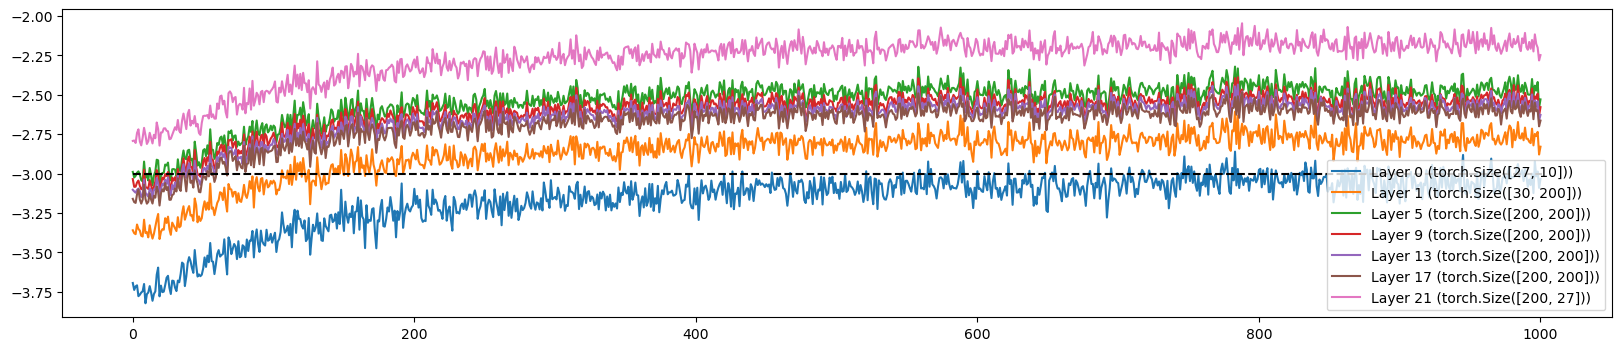

In [152]:
plt.figure(figsize=(20,4))
legends = []
for i, p in enumerate(parameters):
    if p.squeeze().ndim == 2:
        t = p.grad
        plt.plot([update_to_weight[j][i] for j in range(len(update_to_weight))])
        legends.append(f"Layer {i} ({p.shape})")

plt.plot([0, len(update_to_weight)], [-3, -3], 'k--')
plt.legend(legends)

- the update to weight ratio for the Ws is wonderful (between 1e-2.5 to 1e-3.5), so the weights will change by 0.1% to 0.3% in the next step

- try changing the calibration and make it less perfect (play with the gain a little bit or even remove the weights calibration -the division by the fan-in), and you will see that the effect is now mitigated by the batch norm (the activations and gradients are still well-behaved and won't be affected)
    - however, the update to weight ratio will be affected because of the backward pass of the batch norm
        - we didn't talk about the details of that because it needs an intuitive understanding of the backward pass
        - mine: the weights are messed up and uncalibrated well enough so they will have larger and higher updates, despite that the activations and the gradients will be well-behaved
        - so, we may want to re-tune the learning rate if we change the calibration of the weights while using batchnorm
            - if the ratios are at 1e-4 for example, then we may want to increase the learning rate by 10 times (to get it to 1e-3)

### use improper initialization and see the effect of the batch norm

In [158]:
n_embed = 10 
n_hidden = 200 
g = torch.Generator().manual_seed(2147483647)


C = torch.randn((vocab_size, n_embed) , generator=g)

# first the model with no batch norm
layers = [
    Linear(n_embed * block_size, n_hidden), BatchNorm1d(n_hidden), Tanh(), 
    Linear(n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size), BatchNorm1d(vocab_size)
]

# weight initialization (we already adjusted the weights, and now remains the gain)
with torch.no_grad():
    # make gamma small to make the batch norm less confident
    layers[-1].gamma *= 0.1 
    # multiply the hidden weights before the tanh by 5/3 (gain)
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= 5 #(5/3)

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.numel() for p in parameters))

for p in parameters:
    p.requires_grad = True

174751


In [159]:
steps = 200000
batch_size = 32
lossi = []
update_to_weight = []

for i in range(steps):
    idx = torch.randint(0, x_train.shape[0], (batch_size,), generator=g)
    # Forward pass
    emb = C[x_train[idx]]
    x = emb.view(-1, block_size * n_embed)
    for layer in layers:
        x = layer(x)

    # Compute loss
    loss = F.cross_entropy(x, y_train[idx])


    ## Visualization purposes: Retain output gradients
    for layer in layers:
        layer.out.retain_grad()

    # Backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # step learning rate decay
    lr = 0.1 if i < 100000 else 0.01

    # Update the parameters
    for p in parameters:
        p.data -= p.grad * lr
    
    # track stats
    if i % 10000 == 0:
        print(f"Step {i/steps*100:.2f}%", loss.item())
    lossi.append(loss.log10().item())

    with torch.no_grad():
        update_to_weight.append([(p.grad.std() * lr / p.data.std()).log10().item() for p in parameters]) 

    if i >= 1000:
        break

Step 0.00% 3.285294771194458


Layer 2 tanh mean: -0.00, std: 0.63, Saturation: 3.25%
Layer 5 tanh mean: 0.00, std: 0.63, Saturation: 3.12%
Layer 8 tanh mean: 0.00, std: 0.64, Saturation: 2.72%
Layer 11 tanh mean: -0.00, std: 0.64, Saturation: 2.84%
Layer 14 tanh mean: 0.00, std: 0.64, Saturation: 2.83%


Text(0.5, 1.0, 'Activations distribution')

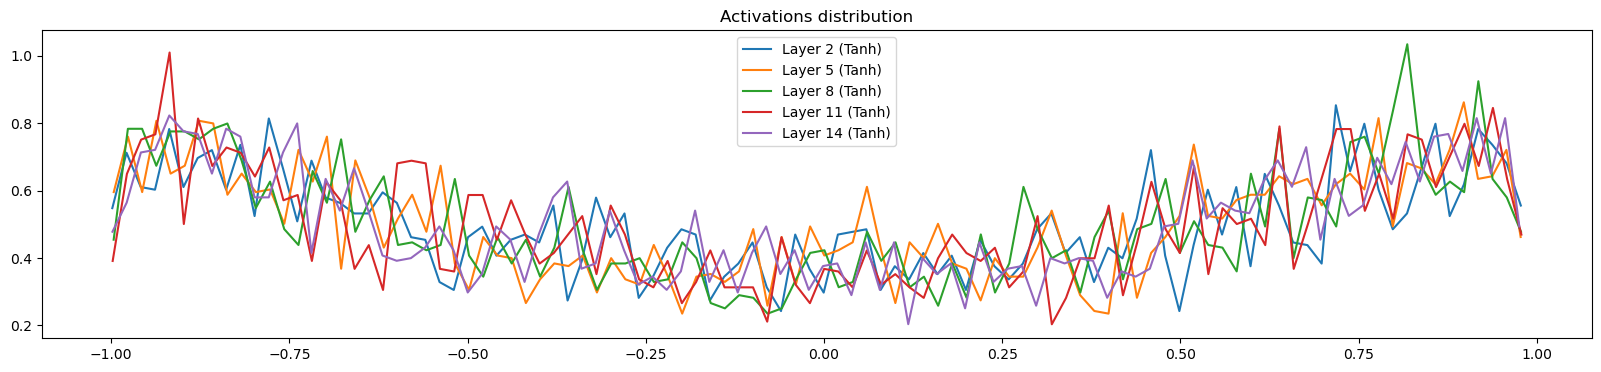

In [160]:
plt.figure(figsize=(20,4))
legends = []

for i, layer in enumerate(layers):
    if isinstance(layer, Tanh):
        t = layer.out # the output of the tanh
        print(f"Layer {i} tanh mean: {t.mean().item():.2f}, std: {t.std().item():.2f}, Saturation: {(t.abs() > 0.97).float().mean().item()*100:.2f}%")
        hy, hx = torch.histogram(t, density=True) # get the histogram of the tanh output, hx is the bin edges, and hy is the bin values
        plt.plot(hx[:-1].detach(), hy.detach()) 
        legends.append(f"Layer {i} ({layer.__class__.__name__})")

plt.legend(legends)
plt.title("Activations distribution")

Layer 2 tanh mean: 0.00, std: 0.002838
Layer 5 tanh mean: 0.00, std: 0.002404
Layer 8 tanh mean: 0.00, std: 0.002119
Layer 11 tanh mean: 0.00, std: 0.001878
Layer 14 tanh mean: 0.00, std: 0.001704


Text(0.5, 1.0, 'Gradients distribution')

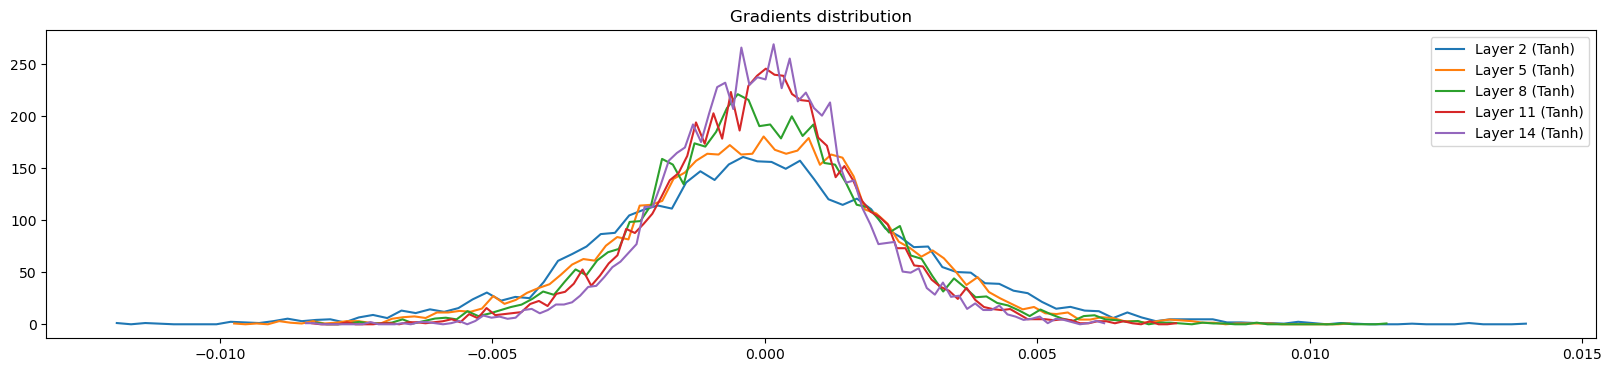

In [161]:
plt.figure(figsize=(20,4))
legends = []

for i, layer in enumerate(layers):
    if isinstance(layer, Tanh):
        t = layer.out.grad # the output of the tanh
        print(f"Layer {i} tanh mean: {t.mean().item():.2f}, std: {t.std().item():.6f}")
        hy, hx = torch.histogram(t, density=True) # get the histogram of the tanh output, hx is the bin edges, and hy is the bin values
        plt.plot(hx[:-1].detach(), hy.detach()) 
        legends.append(f"Layer {i} ({layer.__class__.__name__})")

plt.legend(legends)
plt.title("Gradients distribution")

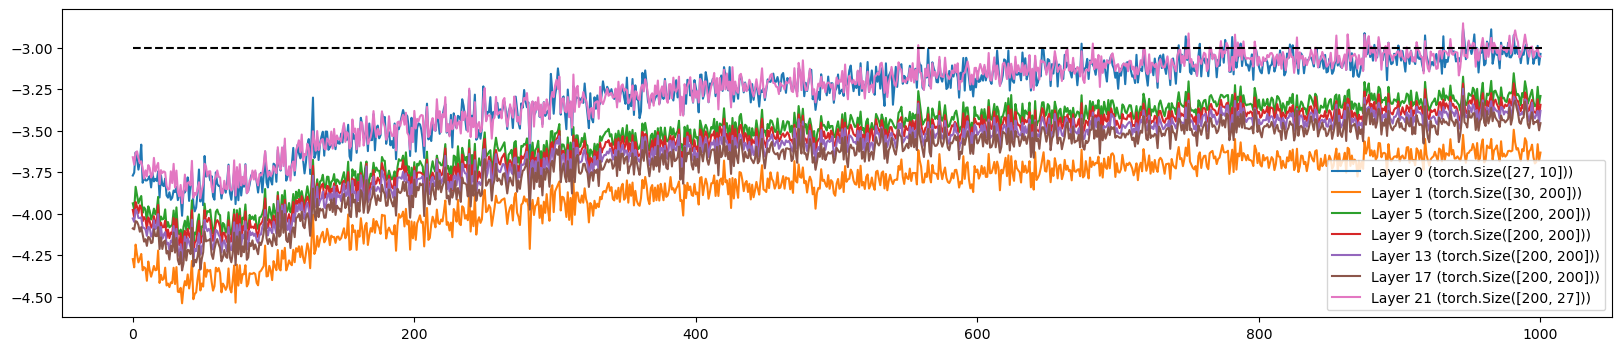

In [162]:
plt.figure(figsize=(20,4))
legends = []
for i, p in enumerate(parameters):
    if p.squeeze().ndim == 2:
        t = p.grad
        plt.plot([update_to_weight[j][i] for j in range(len(update_to_weight))])
        legends.append(f"Layer {i} ({p.shape})")

plt.plot([0, len(update_to_weight)], [-3, -3], 'k--')
plt.legend(legends)

- we see that the activations and distributions are roughly unaffected (the std and mean are roughly the same for both activations and gradients)
- and from the update to ratio graph we see that they are close to each other (which is an indication of well calibrated network), but they have gotten below -3!!
    - so even though batch norm helps with improper initialization by mitigating its effect, we might want to re-tune the learning rate

- `long-story short, the batch norm made the neural net more robust to unperfect gain multiplication -to calibrate the activation functions- or even division by the fan-in -to calibrate the weights-, we will still have well-behaved activations and gradients, but the update to weight ratio will be affected and we will need to re-tune the learning rate to make sure that the weights are learning at the right rate`

## Finally: train the neural network (now well-calibrated and using batchnorm)

In [167]:
steps = 200000
batch_size = 32
lossi = []
update_to_weight = []

for i in range(steps):
    idx = torch.randint(0, x_train.shape[0], (batch_size,), generator=g)
    # Forward pass
    emb = C[x_train[idx]]
    x = emb.view(-1, block_size * n_embed)
    for layer in layers:
        x = layer(x)

    # Compute loss
    loss = F.cross_entropy(x, y_train[idx])


    ## Visualization purposes: Retain output gradients
    for layer in layers:
        layer.out.retain_grad()

    # Backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # step learning rate decay
    lr = 0.1 if i < 100000 else 0.01

    # Update the parameters
    for p in parameters:
        p.data -= p.grad * lr
    
    # track stats
    if i % 10000 == 0:
        print(f"Step {i/steps*100:.2f}%", loss.item())
    lossi.append(loss.log10().item())

    with torch.no_grad():
        update_to_weight.append([(p.grad.std() * lr / p.data.std()).log10().item() for p in parameters]) 


Step 0.00% 3.291944980621338
Step 5.00% 2.316462278366089
Step 10.00% 1.8940284252166748
Step 15.00% 1.8924602270126343
Step 20.00% 2.46712327003479
Step 25.00% 2.282064914703369
Step 30.00% 1.6981029510498047
Step 35.00% 2.157022476196289
Step 40.00% 2.0634305477142334
Step 45.00% 1.8412517309188843
Step 50.00% 1.6510546207427979
Step 55.00% 2.100872278213501
Step 60.00% 1.733057975769043
Step 65.00% 1.7527064085006714
Step 70.00% 1.9698482751846313
Step 75.00% 1.8911839723587036
Step 80.00% 1.931816577911377
Step 85.00% 2.2201623916625977
Step 90.00% 2.014312982559204
Step 95.00% 1.8728396892547607


In [177]:
@torch.no_grad() # this disables gradient computation, saves memory, and speeds up computation for the following function
def evaluate(split):
    x, y = {
        'train': (x_train, y_train),
        'val': (x_val, y_val),
        'test': (x_test, y_test)
    }[split]
    emb = C[x]
    x = emb.view(-1, block_size * n_embed)
    for layer in layers:
        if isinstance(layer, BatchNorm1d):
            layer.training = False
        x = layer(x)
    loss = F.cross_entropy(x, y)
    print(f"{split} loss: {loss.item()}")

evaluate('train')
evaluate('val')

train loss: 1.9721887111663818
val loss: 2.0719614028930664


- we got a very similar results to what we got in the previous notebook (when i used optuna to find the most optimal hyperparameters!! on a context length of 4!!), that is because `batchNorm` helps when we have optimization bottlenecks (mine: so we get the best what we can get with batchnorm, and perfectly calibrated netowrk in terms of optimization)

- the performance of this stage is actually now bottlenecked by the context length and the architecture (to make use of more context)
    - that is indeed what we will do using RNNs and Transformers to push the performance further

## Sample from the model

In [179]:
g = torch.Generator().manual_seed(2147483647)

for _ in range(20):
    out = []
    context = [0] * block_size # we start with the '.' index, block_size times
    while True:
        emb = C[torch.tensor(context)] # 1Xblock_size -> 1Xblock_sizeXemb_dim
        x = emb.view(1, -1)
        for layer in layers:
            x = layer(x)
        probs = F.softmax(x, dim=1)
        next_char_idx = torch.multinomial(probs.view(-1), 1).item()
        context = context[1:] + [next_char_idx] # shift the context by one
        out.append(next_char_idx)
        if next_char_idx == 0:
            break

    # print the example now
    print(''.join([itos[i] for i in out]))

taharlin.
audro.
sammi.
mauri.
nissiellahmiyael.
adoreaveriel.
alee.
coashmir.
aubria.
katrez.
maty.
remarret.
sherie.
mariya.
aubren.
jacque.
hala.
alyxx.
charystira.
jelin.


## Mine: Takaways and Lecture Recap
- we first studied the impact of different initializations on the network performance
    - we studied how we want the logits before the softmax activation to be small and comparable to each other (because when we have small and comparable logits, the probabilities will be comparable and therefore we don't give more confidence to some characters than others randomly at the beginning)
        - we saw that when the logits were not comparable, we gave more confidence to some characters than others randomly -made the the network confidently wrong- and that made the loss very high at the beginning
        - then we saw that the solution is to make the logits equal to each other so that we have equal probabilities for all characters at the beginning (not exactly equal but comparable so that we break the symmetry)
        - so we multiplied the weights by small number (like 0.01) and set the biases to 0 so that the logits are comparable (small and around 0)
        - this gave us a good starting loss and ended up with a better loss (because the optimization function didn't have to spend the first steps to make the logits comparable to each other before re-arrainging them to give the right probabilities)
    - we then studied how we want the logits before the tanh activation to be small and around 0
        - we saw that when the logits were extreme (taking large range of random values), they were at the flat regions of the tanh activation function, therefore in backpropagation, the local gradients were 0, so no matter what the upstream gradients are, they will be multiplied with 0 and destroyed
            - (because no matter how much we nudge the weights around the flat region, the output will be the same, therefore the loss will be the same) and the weights will not be updated
            - we also saw that since most examples are at the flat region initially, the weights will receive gradients from very few examples (and if somehow all examples are at the flat region, the weights will never receive gradients, therefore the neuron will be dead)
        - then we saw that the solution is to make the logits small and around 0 initially, therefore avoiding the flat regions of the tanh activation
        - so, we also multiplied the weights with a small number (like 0.1) and multiplied the biases with 0 or a small number as well
        - this modification ended up with a better loss
    - so in general, we don't want the logits to be too large (therefore will be at the saturation region for most activation functions, and will introduce wrong confidence for the softmax), and we don't want them to be too small either (therefore for most of the activations, it will be like we don't have any nonlinearity, like the sigmoid and the tanh for the tight region around 0 are almost linear)
        - so we want to the distribution to be gaussian -at least in the beginning- (with mean 0 and std 1) -that is another way of saying we want the logits to be small numbers around 0- and we want that distribution to be preserved as we go through the network (so no matter how deep the network is, we don't want any layer to affect and change that distribution for the layer after it)
    

- so, we studied a more principled approach to initialization (because we can't just multiply with any number like we did above)
    - so the `kaiming initialization` was introduced, and it is a systematic way of initializing the weights
    - we basically take into account the number of inputs to the neuron, because if we have more inputs, each neuron will have more W terms to multiply with and sum up, and vice versa
    - so, we sample the weights from a gaussian distribution and we multiply the weights by $\frac{1}{\sqrt{n_{inputs}}}$, this factor is specifically chosen so that the output logits have the same distribution as the inputs

- after managing to adjust and calibrate the weights to make the logits have the same distribution, we saw that the activation functions tend to change that distribution (mine: they basically squash the values to a certain range)
    - the `tanh` squashes the Zs to -1 and 1
    - the `relu` squashes the negative values to 0 (roughly discarding half of the distribution if it was gaussian with mean 0 and std 1-)
    - the `sigmoid` squashes the Zs to 0 and 1
    - and so on
- so, people learned to multiply the weights by some gain (making the distribution little larger to compensate for the squashing of the resulting logits afterwards by the activation functions) -and that is also in addition of multiplying by $\frac{1}{\sqrt{n_{inputs}}}$ to compensate for the weights multiplication-
    - so, for the `tanh` we multiply by 5/3, for the `relu` we multiply by 2 to compensate for discarding half of the distribution, and so on

- so to sum up, we multiply the weights of the linear layer -sampled from a gaussian distribution- by $\frac{\text{gain}}{\sqrt{n_{inputs}}}$, the $\frac{1}{\sqrt{n_{inputs}}}$ is to compensate for the weights multiplication for different input sizes, and the $\text{gain}$ is to compensate for the squashing of the activation functions
    - so for a linear layer followed by a tanh activation, we multiply the weights by $\frac{5/3}{sqrt{n_{inputs}}}$
    - for a linear layer followed by a relu activation, we multiply the weights by $\frac{2}{\sqrt{n_{inputs}}}$


- all the above was extremely essential to do and the neural network (specifically the deep neural networks) were not very forgiving if we didn't make perfect and exact calibration of the weights
    - but as the neural networks got deeper and more complex, it became very difficult to perfectly calibrate the weights to make the logits have the same distribution (it was like balancing a pencil on its tip :D)

- so people have came up with modern innovations that mitigated this, like `residual connections` and also what is called `normalization layers` (like the `batch normalization`)
    - the idea behind `batch norm` was, if we want the distribution of the logits to be roughly gaussian, so why don't we just normalize them to be gaussian :D
    - and we can simply do that because standardizing is a perfectly differentiable operation (we can backpropagate through it)
    $z_{standardized} = \frac{z_{batch} - mean(z)_{batch}}{std(z)_{batch}}$
        - that way, even if we didn't make perfect calibration of the weights, the deep neural network will be more forgiving and the activations will be roughly gaussian and the gradients will be well-behaved 
    - not only that, but also batch norm will rescale that gaussian distribution to any mean and std the neural network likes 
    $z_{rescaled} = \gamma * z_{standardized} + \beta$
        - now the distribution will have a mean of $\beta$ and std of $\gamma$, they are initialized to 0 and 1 respectively to keep the initial distribution to be gaussian, but we make them learnable parameters and update them through backpropagation to let the neural network move the distribution around to any mean and scale it up or down to any std (in case it doesn't like the initial gaussian distribution)
    - and now we just sprinkle batch norm layers throughout the network after every linear layer to control the distribution of the logits at every point in the network
    - one last detail remains, during training, we calculate the mean and std across the batch then use them to standardize the logits before rescaling them 
        - but after training, we might want to use the neural network in production (where we might not have batches, we might have a single example), so how will we feed a single example and get a sensible result? we are expecting a batch of examples to calculate the mean and std across the batch (the neural net expect batches as an input just like training time)
        - so, what we can do is to calculate the mean and std across the entire training set after training, and use these numbers in inference
            - but nobody wants to estimate the mean and std in a second stage or a separate step after we finish training (we are lazy :D)
            - so what people actually do is to calculate the mean and std during training in a running manner (as we train the neural network)
            
                $ \mu_{running} = \mu_{running} * (\text{1 - momentum}) + \mu_{batch} * \text{momentum}$
            
                $ \sigma_{running} = \sigma_{running} * (\text{1 - momentum}) + \sigma_{batch} * \text{momentum}$
            - where the momentum is a hyperparameter that we can set (like 0.1 or 0.01), and it controls how much we want the new batch statistics to update the running statistics, and if we are using a large enough batch size, then the statistics calculated on this batch will be roughly stable and accurate, so we can use a large momentum like 0.1, but for batch sizes as small as 32, the mean and std might take on slightly different numbers from batch to batch (unstable), so we might want to use a smaller momentum like 0.01 or 0.001 (otherwise if we used a large momentum, the running mean and std will be thrashing too much and might not converge to the true mean and std)
            - so, we can use the running mean and std in inference time (much easier than passing through the whole training set -after we finish training- in order to calculate the mean and std that we use in test time)

    - Howerver, the stability offered by batch normalization actually comes at a terrible cost
        - we used to feed a single example through the network, and we calculate its loss and update the weights and biases (this is a deterministic process as we arrive at some logits for the example)
        - then, we started to feed multiple examples (batches of examples) for efficiency, and these batches are processed independently in a vectorized way (also deterministic process)
        - now suddenly in the batch normalization, because we normalize through the batch, we are mathematically coupling these examples together (the mean and std are calculated across the batch)
            - now the logits are no longer independent for each example, as they will change slightly depending on the other examples in the randomly sampled batch (because the mean and std are calculated across the batch) and the logits will sort of jitter around depending on the other examples in the batch
        - so, for that reason, no one likes this layer, it causes a huge amount of bugs, and therefore people tried to avoid it and proposed other alternatives like `layer normalization` and `group normalization` , those became more popular in more recent years, but we haven't covered those yet

    - after that, we learned some diagnostics to know whether the neural network is in a good state or not (well-calibrated)
        - `activations and gradients distributions`: if we did good calibration of the network (or used batch norm), we will see that the activations and gradients distributions gaussians are preserved (they are all same with same std and mean), and that is a sign of a healthy neural network, but if the network is not well-calibrated, we will see that the distributions are not preserved (Asymetric), meaning that the gaussians are either expanding or shrinking as we go through the network
        

    - then we took some examples to visualize these diagnostics
        - example 1: 6 linear layers with no activation functions, we can think of the gain in case of no activation functions as 1, so we just multiply the weights by $\frac{1}{\sqrt{n_{inputs}}}$, 
            - we saw that if we used larger gain than 1, the activations -logits since we have no activation function- and gradients distributions will expand out and not preserved (mine: exploding activations and gradients), and if we used smaller gain than 1, the activations and gradients distributions will shrink and not preserved as well (mine: vanishing activations and gradients)
            - but if we used gain = 1, the distributions will be preserved and well-behaved, they are all gaussian with same std and mean 
        - example 2: 6 linear layers with tanh activation functions, we should multiply the weights by $\frac{5}{3\sqrt{n_{inputs}}}$
            - we saw that if we used the proper gain (5/3), the activations -not the logits this time- and gradients distributions will be preserved and well-behaved, (the std and mean and the saturation percentage are roughly the same for all layers)
            - but if we used lower or higher gain than 5/3, the activations and gradients distributions are not preserved (the activations distribution changes as we go from layer 1 to 9), and the gradients distribution also changes as we go from layer 9 to 1
                - to exactly explain the patterns we see in these graphs, we need an intuitive understanding of what the activation function does -in order to understand activation patterns- and what the backpropagation does -in order to understand the gradients patterns-
                    - we studied the activation function and managed to interpret the patterns we see in the activation distributions (that is the saturation %), but we didn't delve into the details of backpropagation in order to interpret the gradients distributions
                - for now what we care about is whether the distributions of the activations are preserved through forward prop -and don't change as we go through the network-, and whether the gradients distributions are preserved through back prop -and don't change as we go back through the network-
                    - otherwise if there is a change in the distributions of both activations and gradients, then we have a problem in the network

        - then we learned about one more diagnostic
            - `update to weight ratio`: we measure the update (gradient * learning rate) to the weights ratio (more precisely the std of the update to the std of the weights ratio, and we take the log10 of that) and we do that for all the weights, we want the updates to be around 0.1% of the weights (that is 0.1/100 = 0.001), so we want the ratio to be around 1e-3 $\frac{\text{learning rate}*gradient}{weights} = 1e^{-3} (0.001)$, which is -3 on the log10 plot, that diagnostic is extremely important for 2 reasons
                - 1. to set the learning rate
                    - if the ratio of all parameters is below 1e-3, that means that $\text{learning rate} * \text{gradient}$ is too small compared to the weights, so we might want to increase the learning rate (if the ratio is around 1e-4, then we might want to increase the learning rate by 10 times to get it to 1e-3 and so on)
                    - if the ratio of all parameters is above 1e-3, that means that $\text{learning rate} * \text{gradient}$ is too large compared to the weights, so we might want to decrease the learning rate (if the ratio is around 1e-2, then we might want to decrease the learning rate by 10 times to get it to 1e-3 and so on)
                - 2. to check the calibration of the network: so this diagnostic can also do what the above diagnostics do! (the activations and gradients distributions)
                    - if there is a sparcity in the ratios of the parameters (they are sparse and different from each other), that means they are receiving different gradients distributions! (because the learning rate is the same for all of them), therefore indicating a problem in the calibration of the network
                    - but if the ratios are close to each other, that means they are receiving the same gradients distributions, therefore the gradients distributions are preserved and the network is well-calibrated
                - ideally, we want them to be close to each other (well-calibrated network), and around 1e-3 -around -3 on the log10 plot- (good learning rate)
        - then we took the same example 2 (6 linear layers with tanh activation functions) and visualized the update to weight ratio
            - case 1: with proper initialization and proper learning rate, we saw that the ratios are close to each other and around 1e-3 (around -3 on the log10 plot), except the final layer, it was around -1 (100 times larger than the other layers), that is because we artificially shrunk the final layer to keep the softmax unconfident (we multiplied the weights by 0.1 to make it less confident in addition to the kaiming initialization)
            - case 2: with proper initialization and too slow learning rate, we saw that the ratios are close to each other and below 1e-3 (around -4 on the log10 plot), that means the learning rate is too slow and we might want to increase it
            - case 3: with improper initialization and proper learning rate, we saw that the ratios are sparse and different from each other, and they all around -3 on the log10 plot, that means the network is not well-calibrated

        - then we added batch norm and repeated the process (6 Linear layers with tanh activation and batch norm added)
            - case 1: proper initialization and proper learning rate
                - we saw that the activations and gradients distributions are preserved (didn't change)
                - and we saw that the update to weight ratio is around 1e-3 (between -2.25 and -3.5), and they are kind of close to each other
            - case 2: improper initialization (whether changing the gain or the not dividing by the square root of fan_in) and proper learning rate
                - we saw that the activations and gradients distributions are preserved (didn't change!) and that is because of the batch norm is mitigating this effect 
                - and from the update to weight ratio, we see that the ratios are close to each other (anther sign of preserved gradient distributions), but we see that they shift away from the -3!
                    - so, we might want to retune the learning rate again
                - `long-story short, the batch norm made the neural net more robust to unperfect gain multiplication -to calibrate the activation functions- or even division by the fan-in -to calibrate the weights-, we will still have well-behaved activations and gradients, but the update to weight ratio will be shifted away from -3 and we will need to re-tune the learning rate to make sure that the weights are learning at the right rate`
                    - that is because we are changing the scale of the logits that are coming into the batch norms (mine: i don't get this point)
    

-  we will study RNNs later (which are very very deep neural networks), that is where a lot of this analysis and normalization layers will become very important for good performance  